In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gpd
import warnings
from census import Census
from us import states
import os
import seaborn as sns
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore
import statsmodels.formula.api as smf
from esda.moran import Moran
from libpysal.weights import Queen
from spreg import OLS as SP_OLS, ML_Lag
import pysal

%matplotlib inline
%config InlineBackend.figure_format ='retina'
warnings.simplefilter(action='ignore', category=FutureWarning)

In [28]:
c = Census("7503d874dc67f8d291480cde3afcf2dc3d5cb890")

In [29]:
variables = [
    'B19013_001E',  # Median household income
    'C16002_004E',  # Spanish: Linguistically isolated
    'C16002_007E',  # Other Indo-European: Linguistically isolated
    'C16002_010E',  # Asian and Pacific Island languages: Linguistically isolated
    'C16002_013E',  # Other languages: Linguistically isolated
    'B11001_001E'   # Total households
]

education_variables = [
    'B15003_001E',   # Total population 25 years and over
    'B15003_022E',  # Bachelor's degree
    'B15003_023E'   # Master's degree
]

employment_variables = [
    'B23025_001E',  # Total in labor force
    'B23025_002E',  # In labor force
    'B23025_004E'   # Employed
]

In [30]:
data = c.acs5.state_county_tract(
    fields=['NAME'] + variables + education_variables + employment_variables,
    state_fips=states.TX.fips,
    county_fips='113',  # FIPS code for Dallas County
    tract='*',
    year=2019
)

In [31]:
df = pd.DataFrame(data)

In [32]:
df['Pct_Bachelors_Degree'] = df['B15003_022E'] / df['B15003_001E'] * 100
df['Pct_Masters_Degree'] = df['B15003_023E'] / df['B15003_001E'] * 100

In [33]:
df['Employment_Rate'] = df['B23025_004E'] / df['B23025_002E'] * 100


In [34]:
df['Pct_Spanish_Linguistically_Isolated'] = df['C16002_004E'] / df['B11001_001E'] * 100
df['Pct_Indo_European_Linguistically_Isolated'] = df['C16002_007E'] / df['B11001_001E'] * 100
df['Pct_Asian_Pacific_Island_Linguistically_Isolated'] = df['C16002_010E'] / df['B11001_001E'] * 100
df['Pct_Other_Languages_Linguistically_Isolated'] = df['C16002_013E'] / df['B11001_001E'] * 100

In [35]:
df['geo_id'] = df['state'] + df['county'] + df['tract']
df = df.drop(columns=['state', 'county', 'tract', 'B15003_001E', 'B23025_001E', 'B23025_002E', 'B23025_004E'])


In [36]:
cols_to_check = [
    'B19013_001E', 'Pct_Spanish_Linguistically_Isolated', 'Pct_Indo_European_Linguistically_Isolated', 
    'Pct_Asian_Pacific_Island_Linguistically_Isolated', 'Pct_Other_Languages_Linguistically_Isolated'
]
for col in cols_to_check:
    df[col] = df[col].apply(lambda x: np.nan if x < 0 else x)

for col in cols_to_check:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [37]:
df = df.rename(columns={
    'B19013_001E': 'Median_Income',
    'C16002_004E': 'Spanish_Linguistically_Isolated',
    'C16002_007E': 'Indo_European_Linguistically_Isolated',
    'C16002_010E': 'Asian_Pacific_Island_Linguistically_Isolated',
    'C16002_013E': 'Other_Languages_Linguistically_Isolated',
    'B15003_022E': 'Bachelors_Degree',
    'B15003_023E': 'Masters_Degree',
    'Pct_Bachelors_Degree': 'Pct_Bachelors_Degree',
    'Pct_Masters_Degree': 'Pct_Masters_Degree',
    'Employment_Rate': 'Employment_Rate',
    'B11001_001E' : 'Total Households'
})

In [38]:
shapefile_url = 'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_48_tract.zip'
dallas_tracts = gpd.read_file(shapefile_url)
dallas_tracts = dallas_tracts[dallas_tracts['COUNTYFP'] == '113']
dallas_tracts = dallas_tracts.rename(columns={'GEOID': 'geo_id'})
merged = dallas_tracts.merge(df, on='geo_id')

In [39]:
independent_vars = ['Pct_Spanish_Linguistically_Isolated', 'Pct_Indo_European_Linguistically_Isolated', 
                    'Pct_Asian_Pacific_Island_Linguistically_Isolated', 'Pct_Other_Languages_Linguistically_Isolated',
                    'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 'Employment_Rate']

# Replace negative values with NaN and fill NaN values with the column mean
for col in independent_vars:
    df[col] = df[col].apply(lambda x: np.nan if x < 0 else x)
    df[col].fillna(df[col].mean(), inplace=True)

# Add a constant to the independent variables matrix (intercept)
X = df[independent_vars]
X = sm.add_constant(X)

# Calculate VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


                                           Variable          VIF
0                                             const  1254.059185
1               Pct_Spanish_Linguistically_Isolated     1.707664
2         Pct_Indo_European_Linguistically_Isolated     1.087706
3  Pct_Asian_Pacific_Island_Linguistically_Isolated     1.146087
4       Pct_Other_Languages_Linguistically_Isolated     1.158757
5                              Pct_Bachelors_Degree     4.612136
6                                Pct_Masters_Degree     4.072096
7                                   Employment_Rate     1.271573


In [40]:
# Define the independent variables (X) and dependent variable (Y)
cols_to_clean = ['Median_Income', 'Pct_Spanish_Linguistically_Isolated', 
                 'Pct_Indo_European_Linguistically_Isolated', 
                 'Pct_Asian_Pacific_Island_Linguistically_Isolated', 
                 'Pct_Other_Languages_Linguistically_Isolated', 
                 'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 
                 'Employment_Rate']

# Drop rows with any NaN values in the relevant columns for regression
df_clean = df.dropna(subset=cols_to_clean)

# Calculate the z-scores for specific columns to identify outliers
cols_to_clean_outliers = ['Median_Income', 'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 'Employment_Rate']
z_scores_outliers = np.abs(zscore(df_clean[cols_to_clean_outliers]))

# Define a threshold for identifying outliers
threshold = 3

# Filter the dataset to exclude rows with z-scores above the threshold for the specified columns
df_no_outliers = df_clean[(z_scores_outliers < threshold).all(axis=1)]

X = df_no_outliers[['Pct_Spanish_Linguistically_Isolated', 'Pct_Indo_European_Linguistically_Isolated', 
                    'Pct_Asian_Pacific_Island_Linguistically_Isolated', 'Pct_Other_Languages_Linguistically_Isolated',
                    'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 'Employment_Rate']]
Y = df_no_outliers['Median_Income']

# Add a constant to the independent variables matrix (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Extract and print important parts of the results
summary = model.summary2().tables[1]
r_squared = model.rsquared
adj_r_squared = model.rsquared_adj
f_statistic = model.fvalue
f_pvalue = model.f_pvalue

print("OLS Regression Results")
print("=" * 30)
print(f"R-squared: {r_squared:.3f}")
print(f"Adjusted R-squared: {adj_r_squared:.3f}")
print(f"F-statistic: {f_statistic:.2f}")
print(f"Prob (F-statistic): {f_pvalue:.2e}")
print("\nCoefficients:")
print(summary[['Coef.', 'P>|t|']])

# Detailed interpretation for each variable
for index, row in summary.iterrows():
    coef = row['Coef.']
    p_value = row['P>|t|']
    if p_value < 0.05:
        sig = "statistically significant"
    else:
        sig = "not statistically significant"
    
    if coef < 0:
        effect = "negative"
    else:
        effect = "positive"
    
    print(f"The coefficient for {index} is {coef:.2f}, which means it has a {effect} effect on the median income. This effect is {sig} (p-value = {p_value:.3f}).")


OLS Regression Results
R-squared: 0.625
Adjusted R-squared: 0.620
F-statistic: 117.66
Prob (F-statistic): 5.30e-101

Coefficients:
                                                         Coef.         P>|t|
const                                            -72331.958071  2.687912e-02
Pct_Spanish_Linguistically_Isolated                -130.940608  1.786958e-01
Pct_Indo_European_Linguistically_Isolated         -3612.648921  3.723546e-06
Pct_Asian_Pacific_Island_Linguistically_Isolated    424.487834  3.740628e-01
Pct_Other_Languages_Linguistically_Isolated       -3302.380459  7.441251e-04
Pct_Bachelors_Degree                                771.469129  9.534706e-09
Pct_Masters_Degree                                 1603.792077  2.125969e-10
Employment_Rate                                    1181.235726  7.880445e-04
The coefficient for const is -72331.96, which means it has a negative effect on the median income. This effect is statistically significant (p-value = 0.027).
The coefficient f

In [41]:
cols_to_check = ['Median_Income', 'Pct_Spanish_Linguistically_Isolated', 
                 'Pct_Indo_European_Linguistically_Isolated', 
                 'Pct_Asian_Pacific_Island_Linguistically_Isolated', 
                 'Pct_Other_Languages_Linguistically_Isolated',
                 'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 'Employment_Rate']
correlation = merged[cols_to_check].corr()

In [42]:
# Calculate and print the correlation coefficients for each linguistic isolation category with Median Income

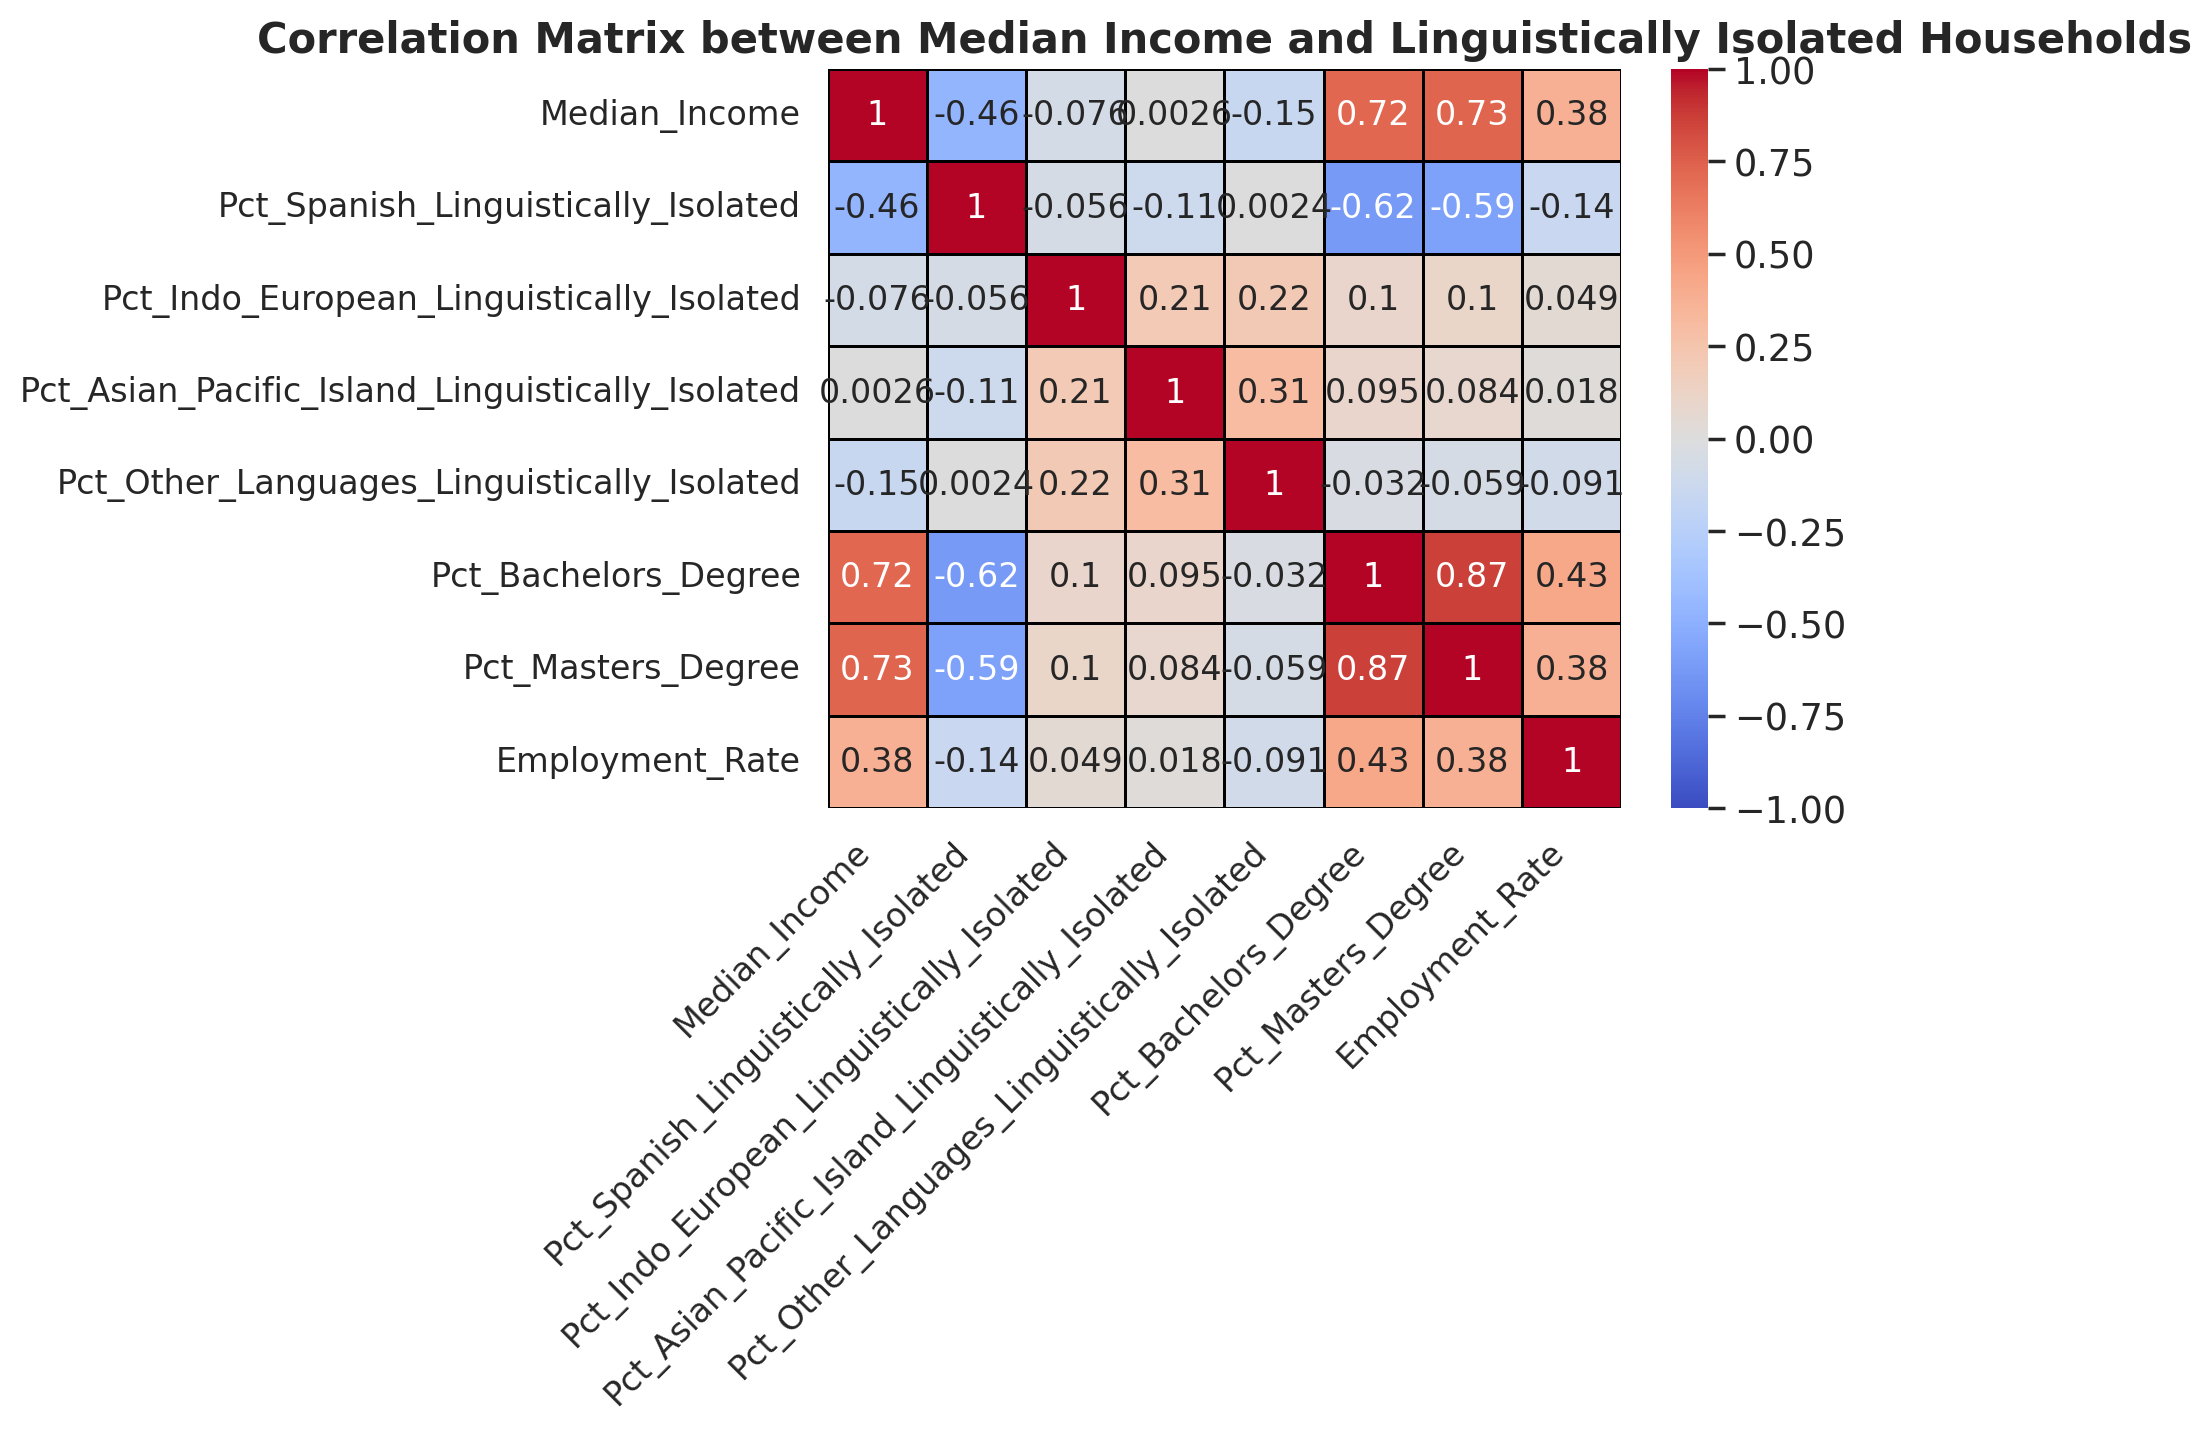

In [43]:
plt.figure()
sns.set(font_scale=1.2)
heatmap = sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, annot_kws={"size": 12}, linewidths=.5, linecolor='black', cmap='coolwarm')
heatmap.set_title('Correlation Matrix between Median Income and Linguistically Isolated Households', fontsize=15, weight='bold')
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show
plt.savefig('correlation_matrix1.png',bbox_inches='tight', format='png')

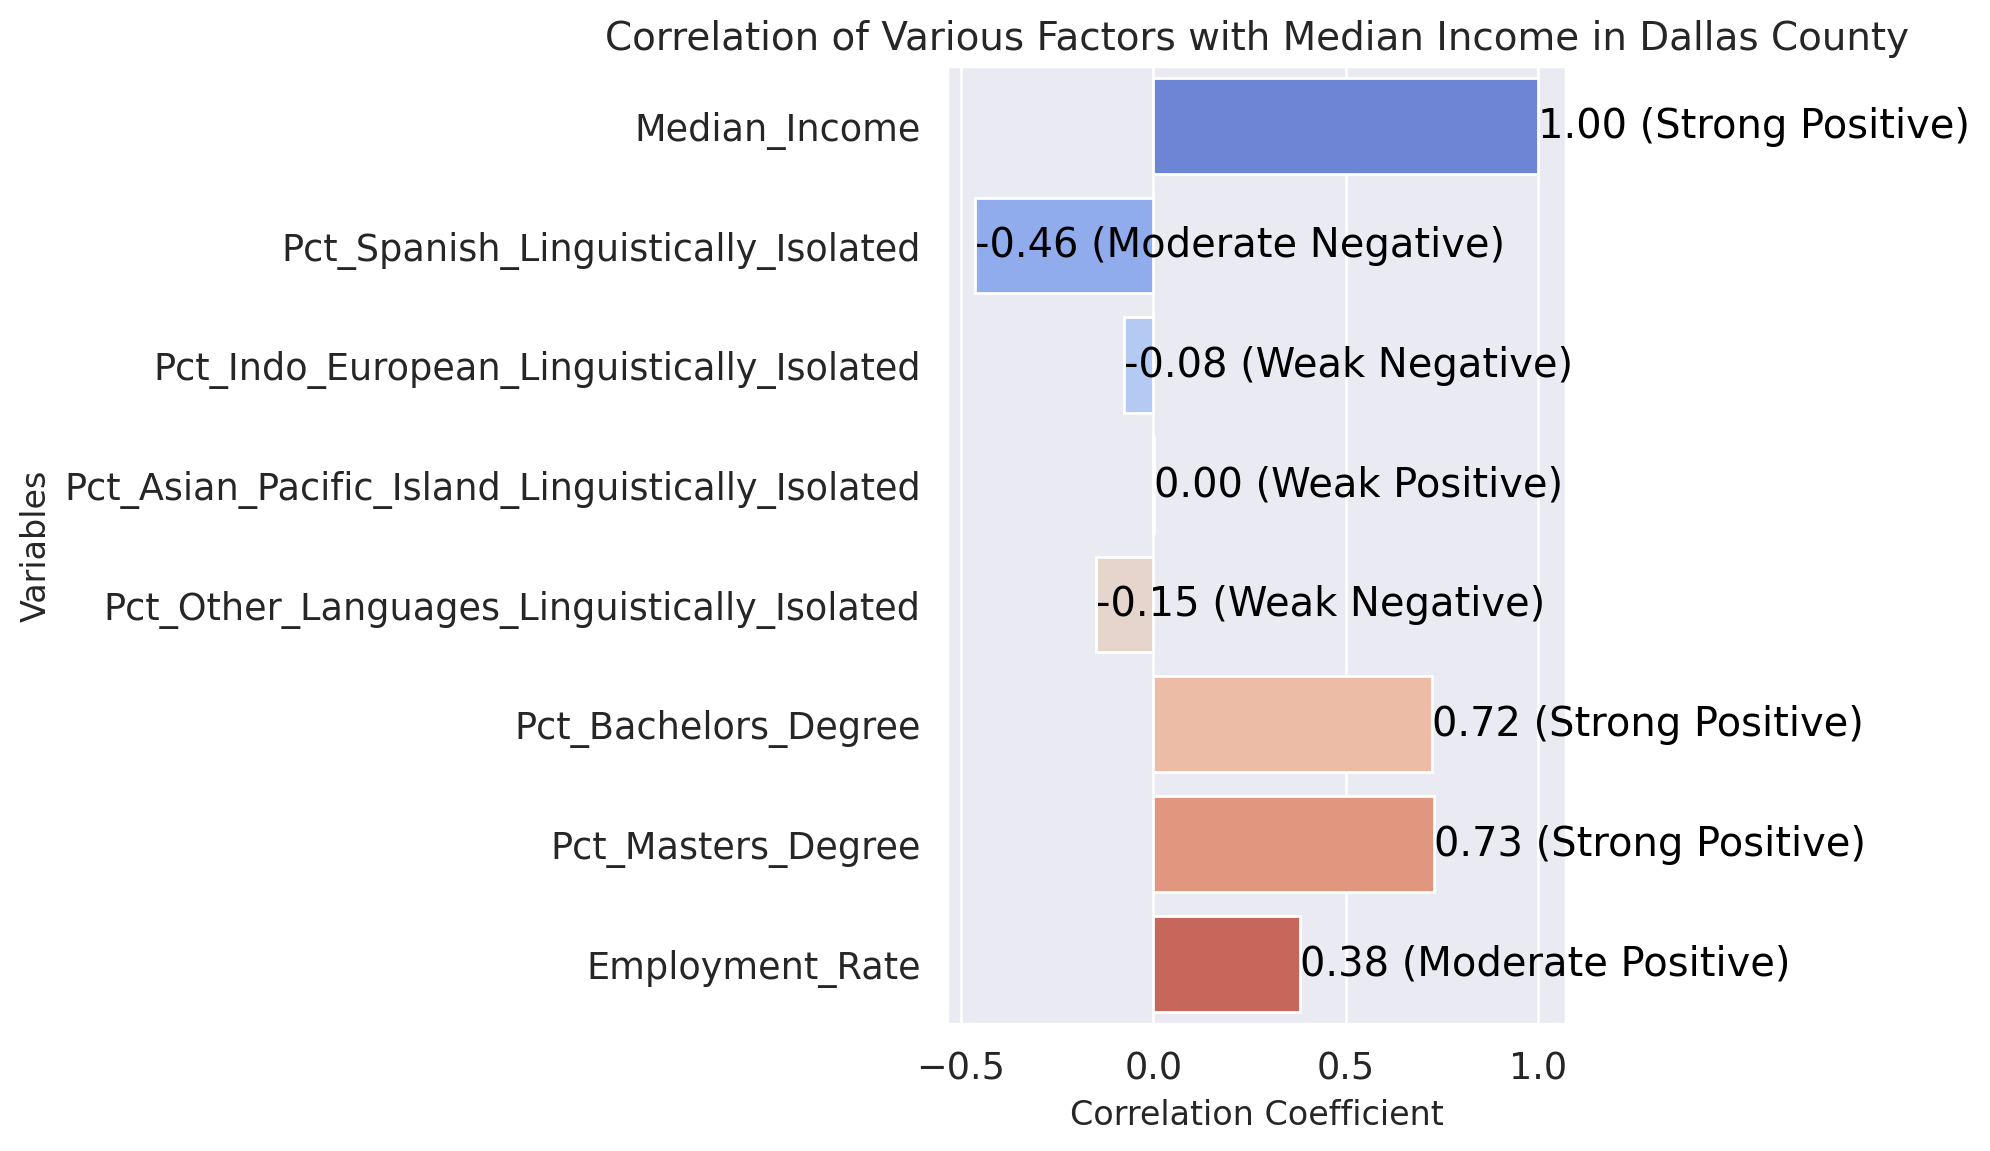

In [44]:
# Create a DataFrame with the correlation data
correlation_data = {
    'Variables': ['Median_Income', 'Pct_Spanish_Linguistically_Isolated', 'Pct_Indo_European_Linguistically_Isolated',
                  'Pct_Asian_Pacific_Island_Linguistically_Isolated', 'Pct_Other_Languages_Linguistically_Isolated',
                  'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 'Employment_Rate'],
    'Correlation with Median Income': [1, -0.462538, -0.076083, 0.00257303, -0.148754, 0.724606, 0.729012, 0.381765],
    'Strength of Correlation': ['Strong Positive', 'Moderate Negative', 'Weak Negative', 'Weak Positive',
                                 'Weak Negative', 'Strong Positive', 'Strong Positive', 'Moderate Positive']
}

df_correlation = pd.DataFrame(correlation_data)

# Plot the correlation data
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation with Median Income', y='Variables', data=df_correlation, palette='coolwarm')

# Add title and labels
plt.title('Correlation of Various Factors with Median Income in Dallas County', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Annotate each bar with the strength of correlation
for index, row in df_correlation.iterrows():
    plt.text(row['Correlation with Median Income'], index, f"{row['Correlation with Median Income']:.2f} ({row['Strength of Correlation']})", 
             color='black', ha="left", va="center")

# Display the plot
plt.tight_layout()
plt.savefig('Correlation_with_Median_Income.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
income_cmap = mcolors.LinearSegmentedColormap.from_list("IncomeMap", ["blue", "lightblue", "white", "yellow", "red"])
percent_cmap = mcolors.LinearSegmentedColormap.from_list("PercentMap", ["lightgrey", "black"])
#percent_cmap = mcolors.LinearSegmentedColormap.from_list("PercentMap", plt.get_cmap('RdPu')(range(256)))


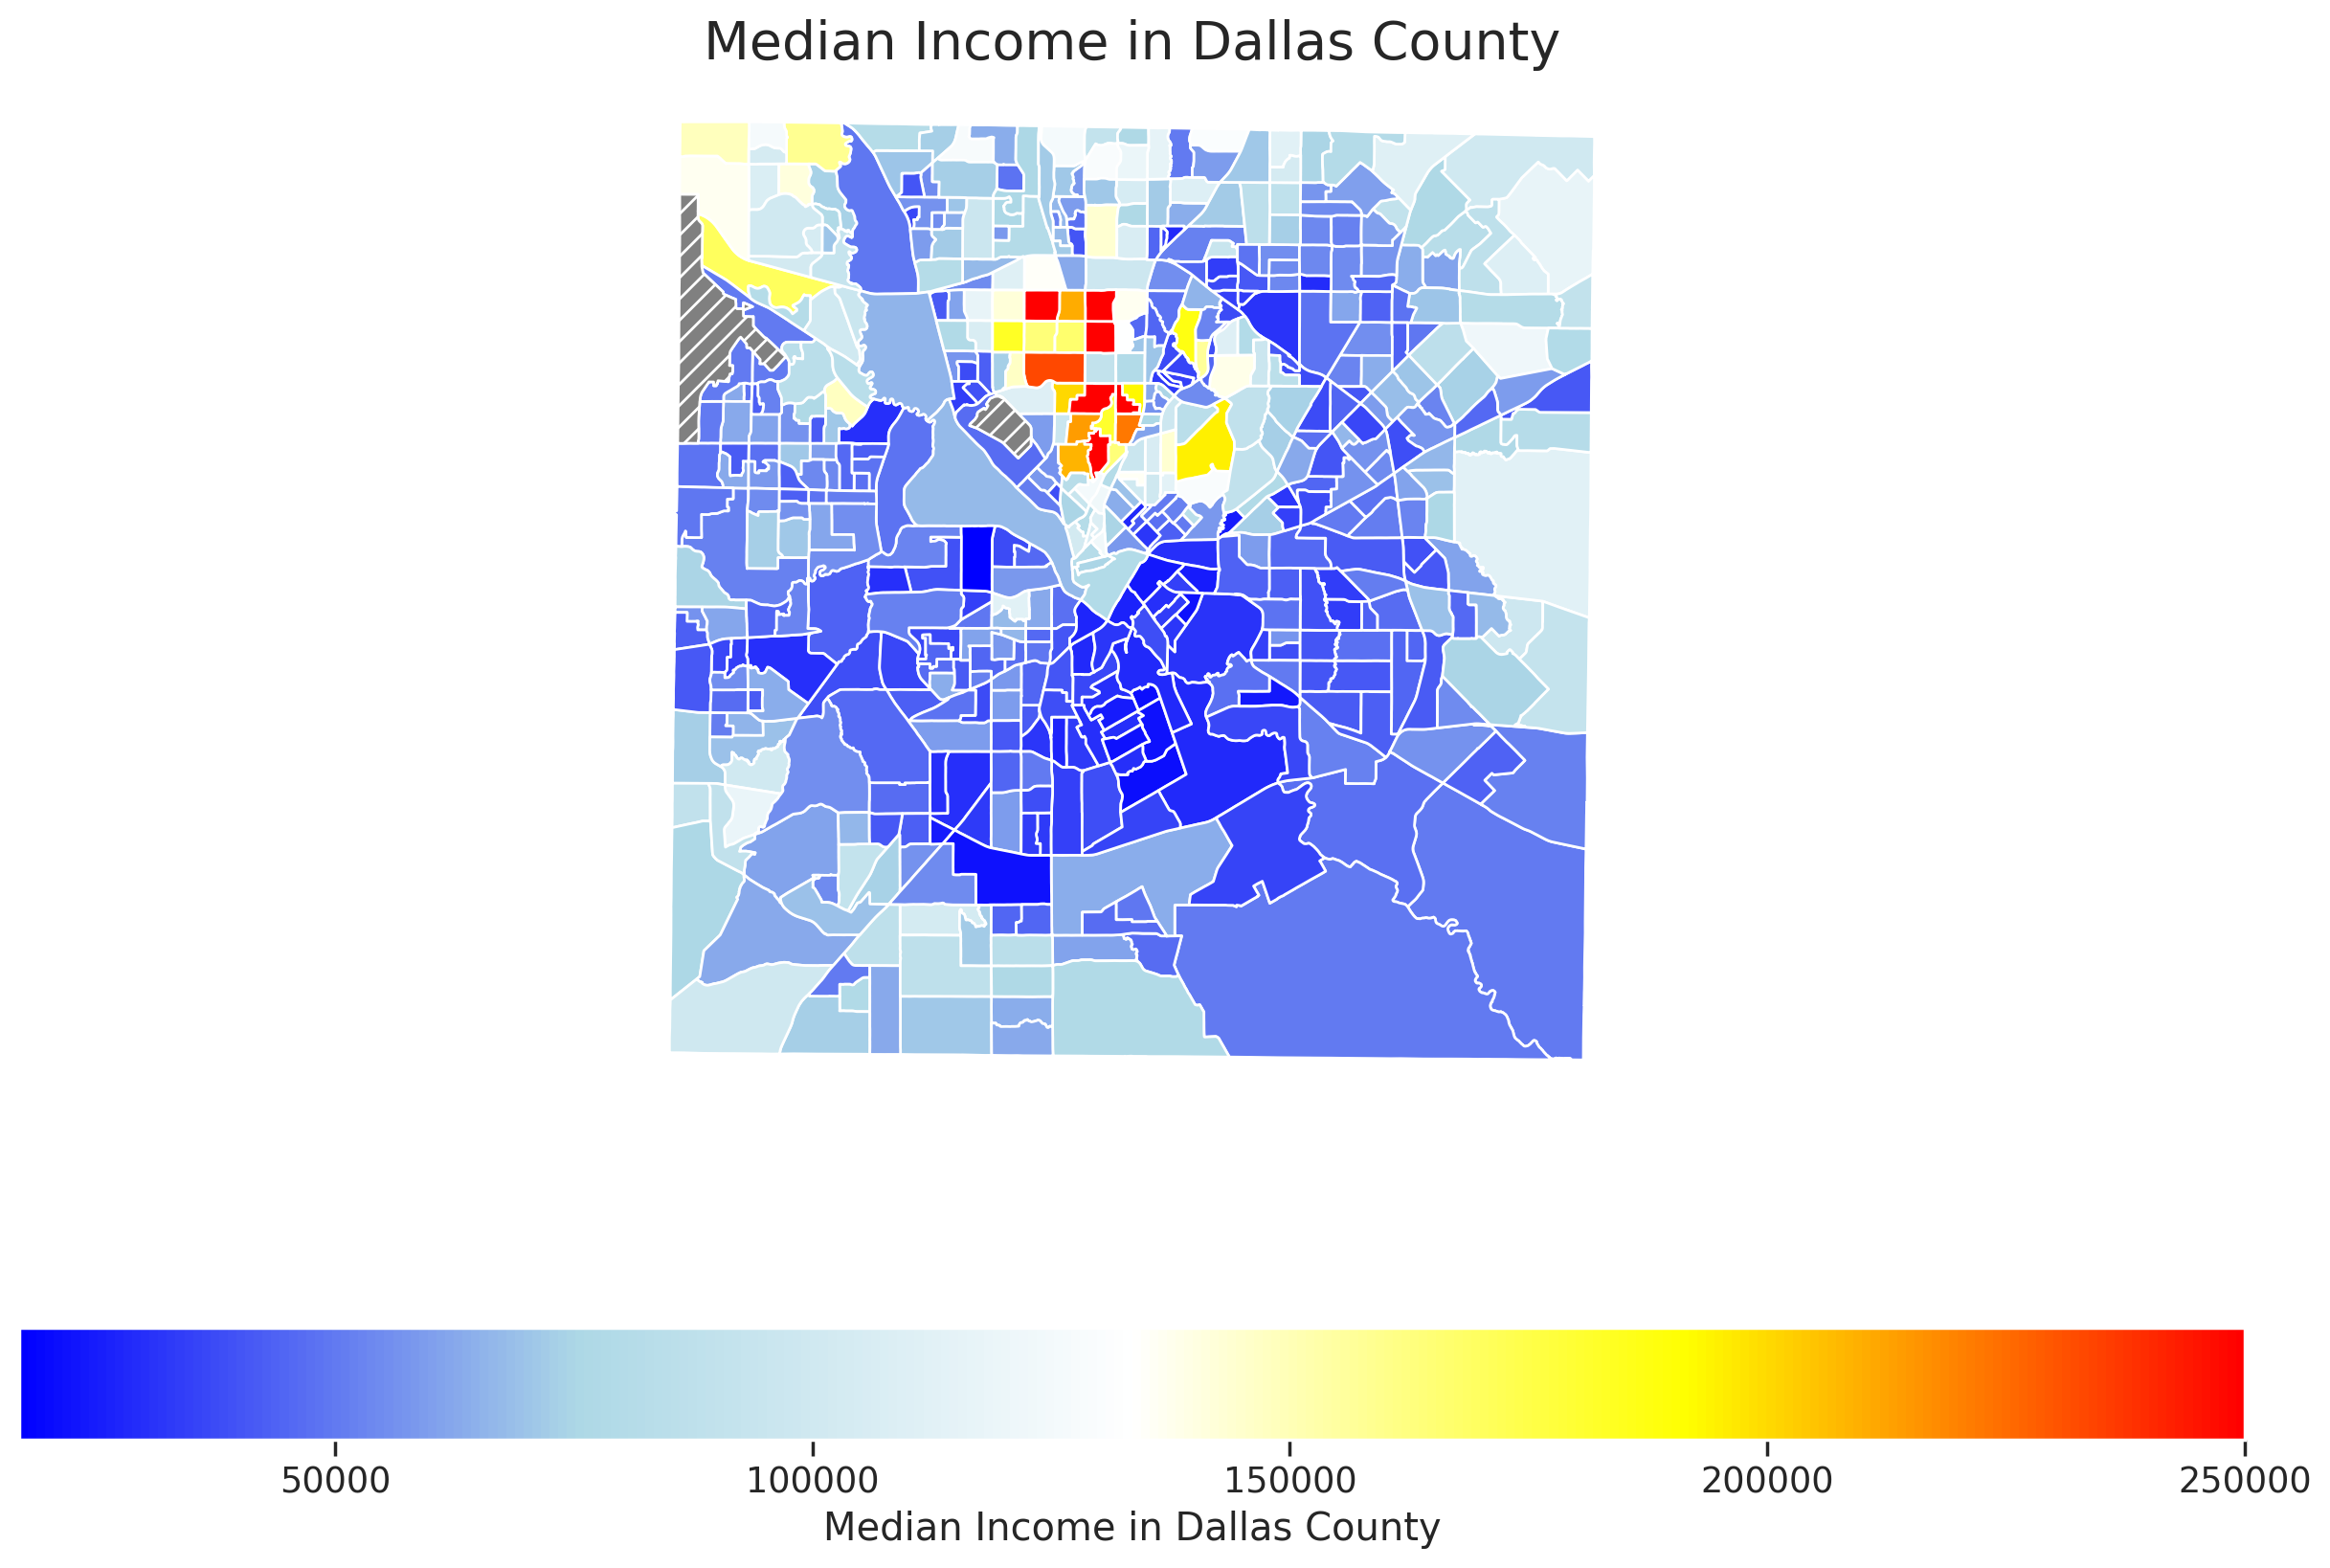

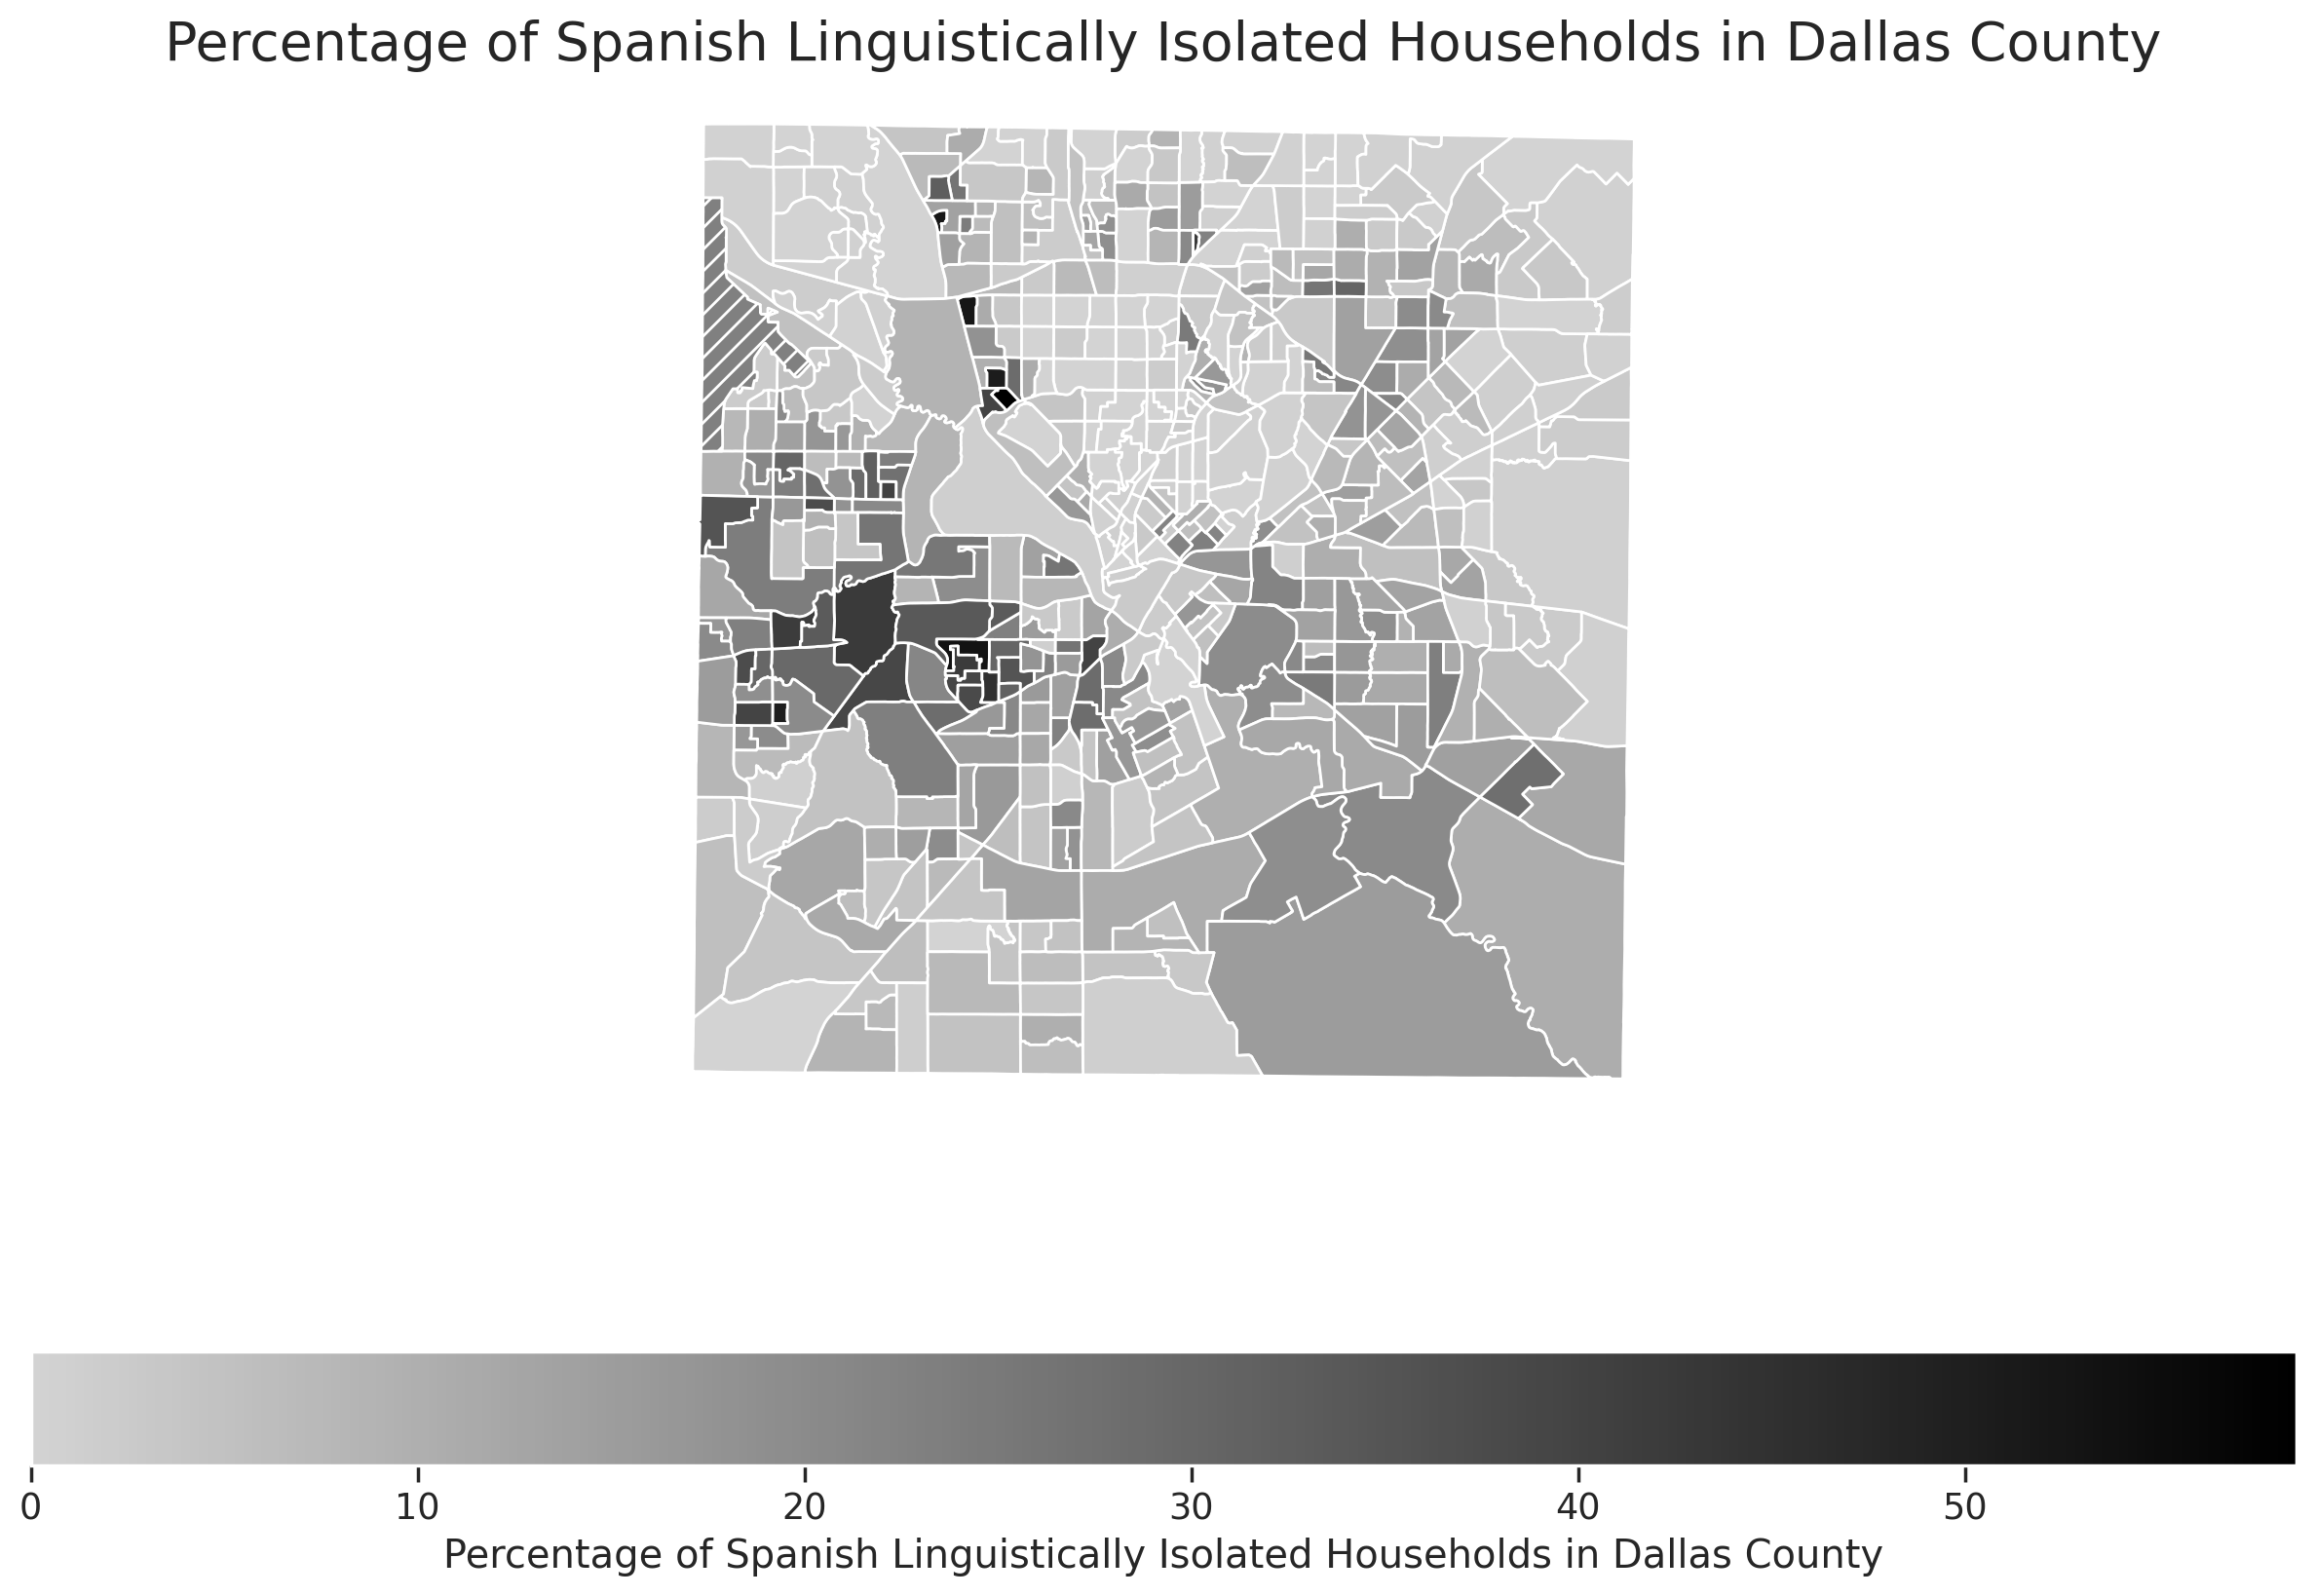

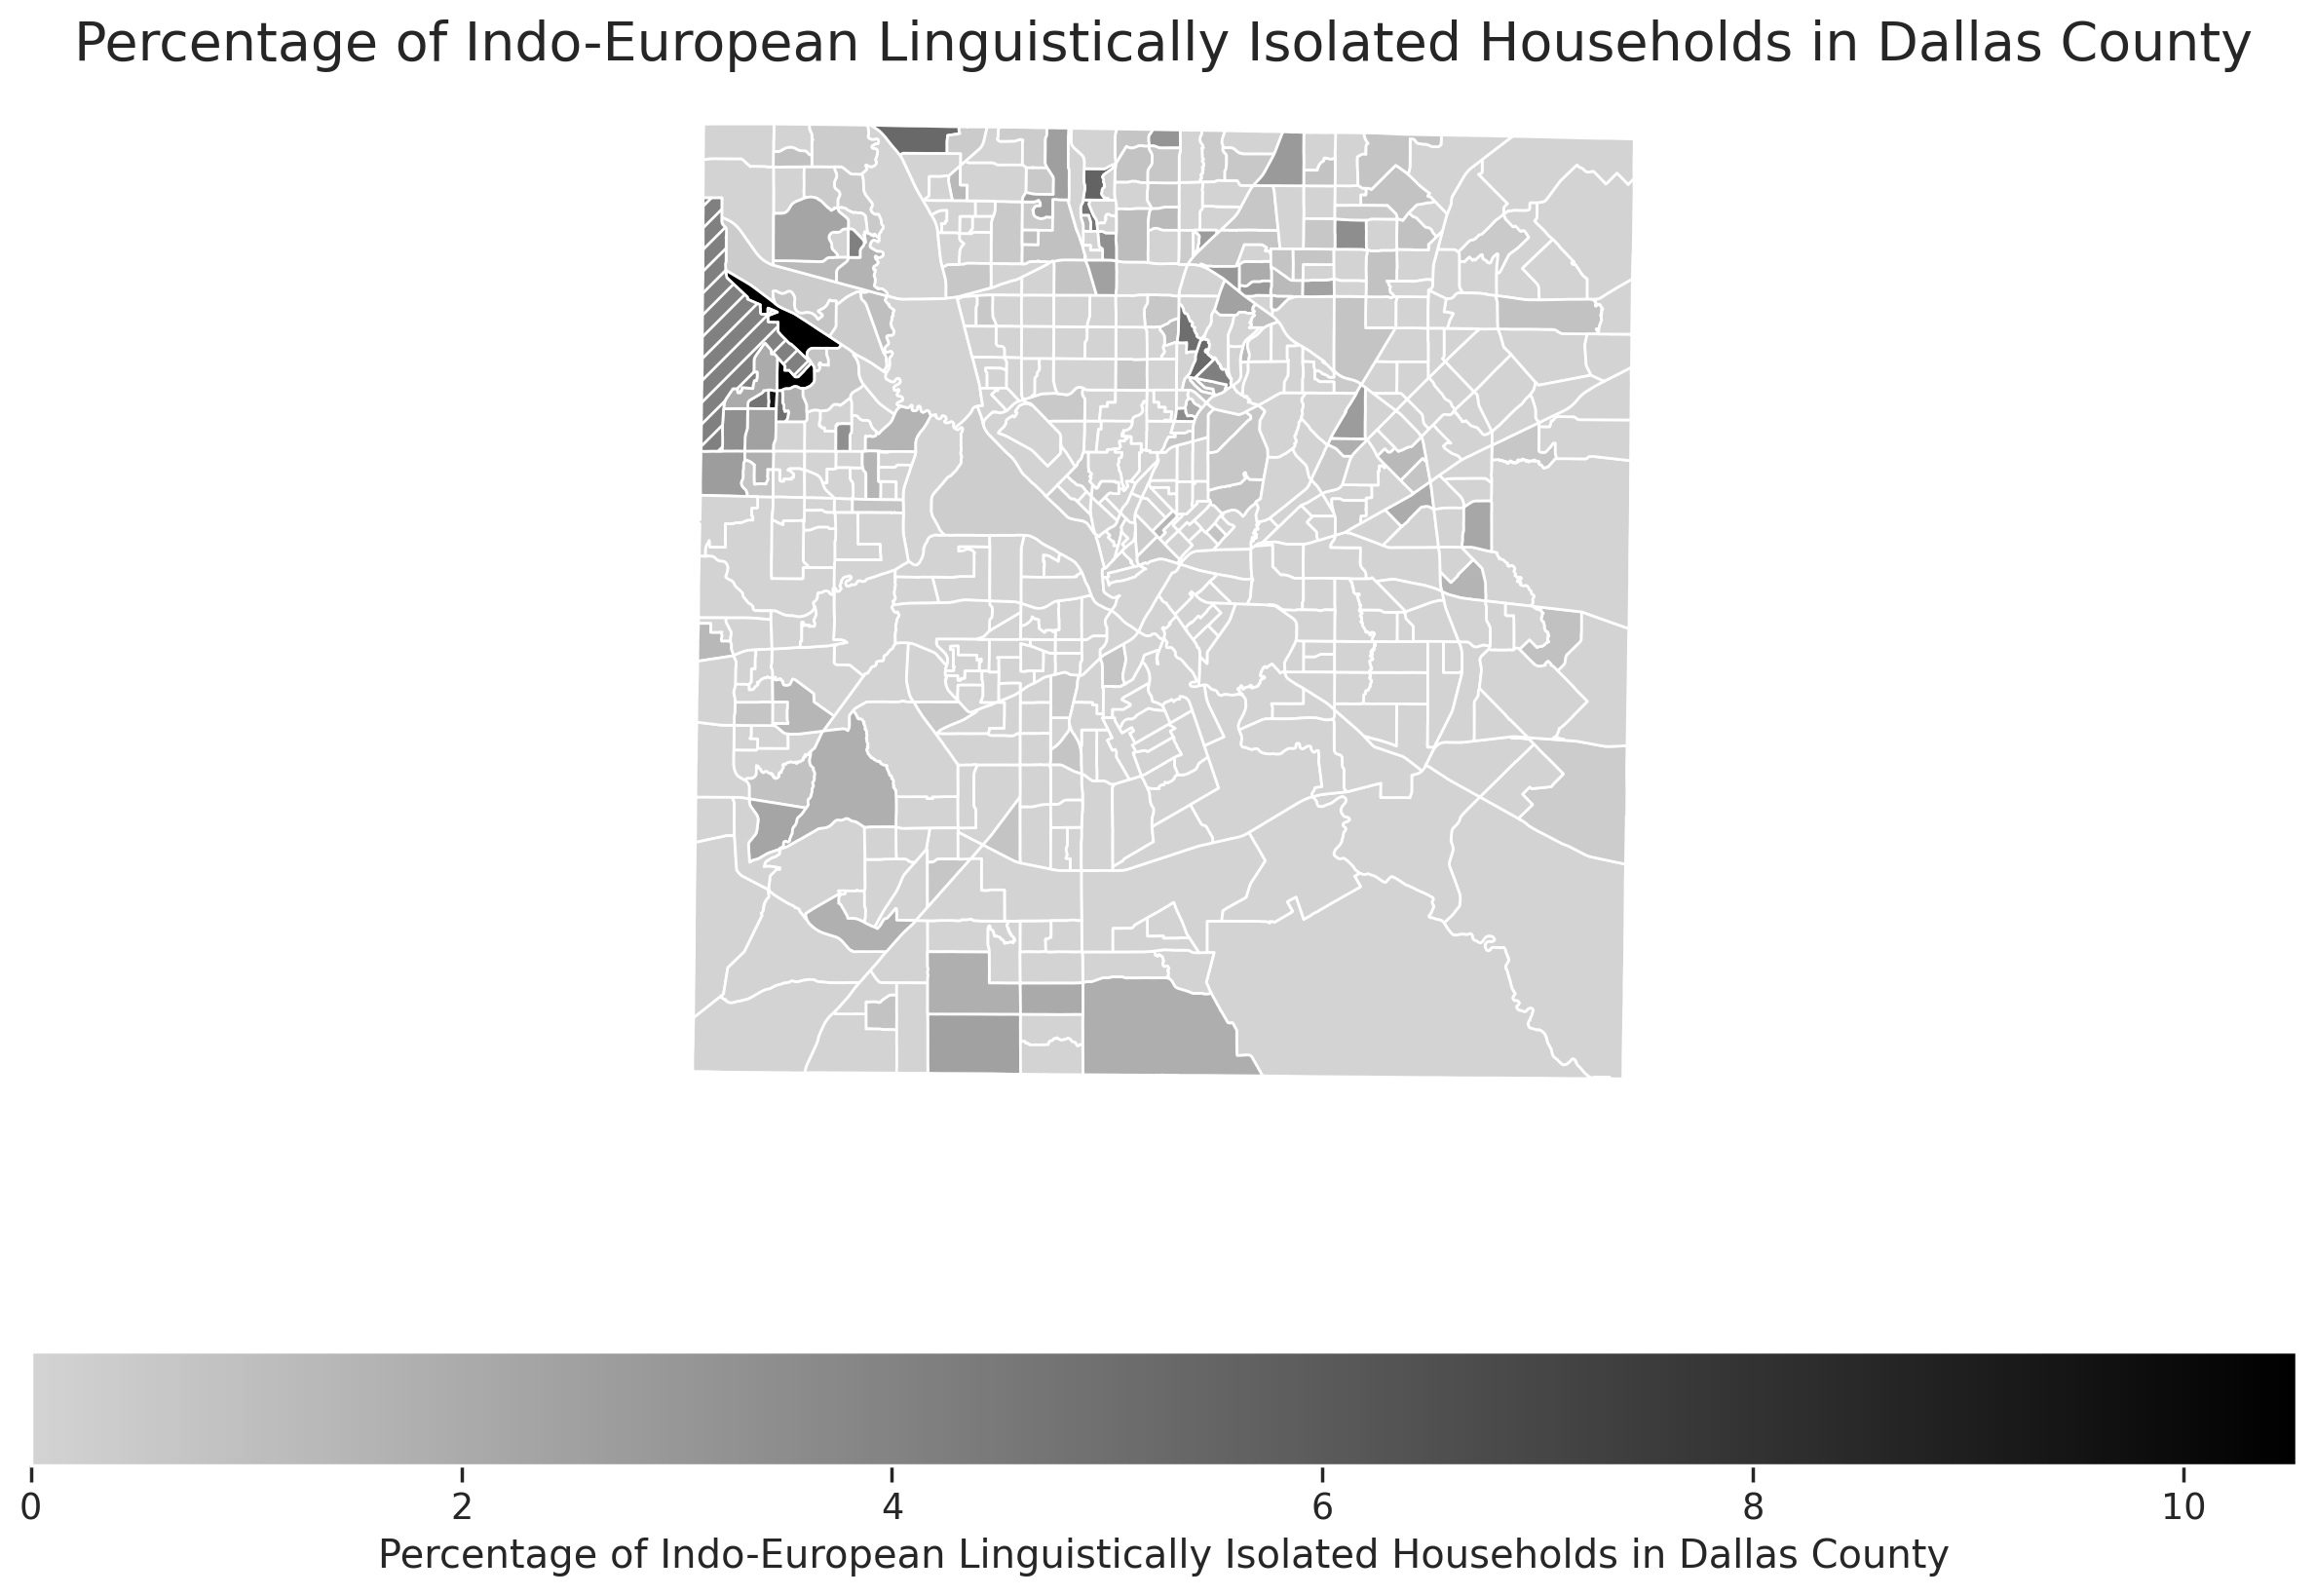

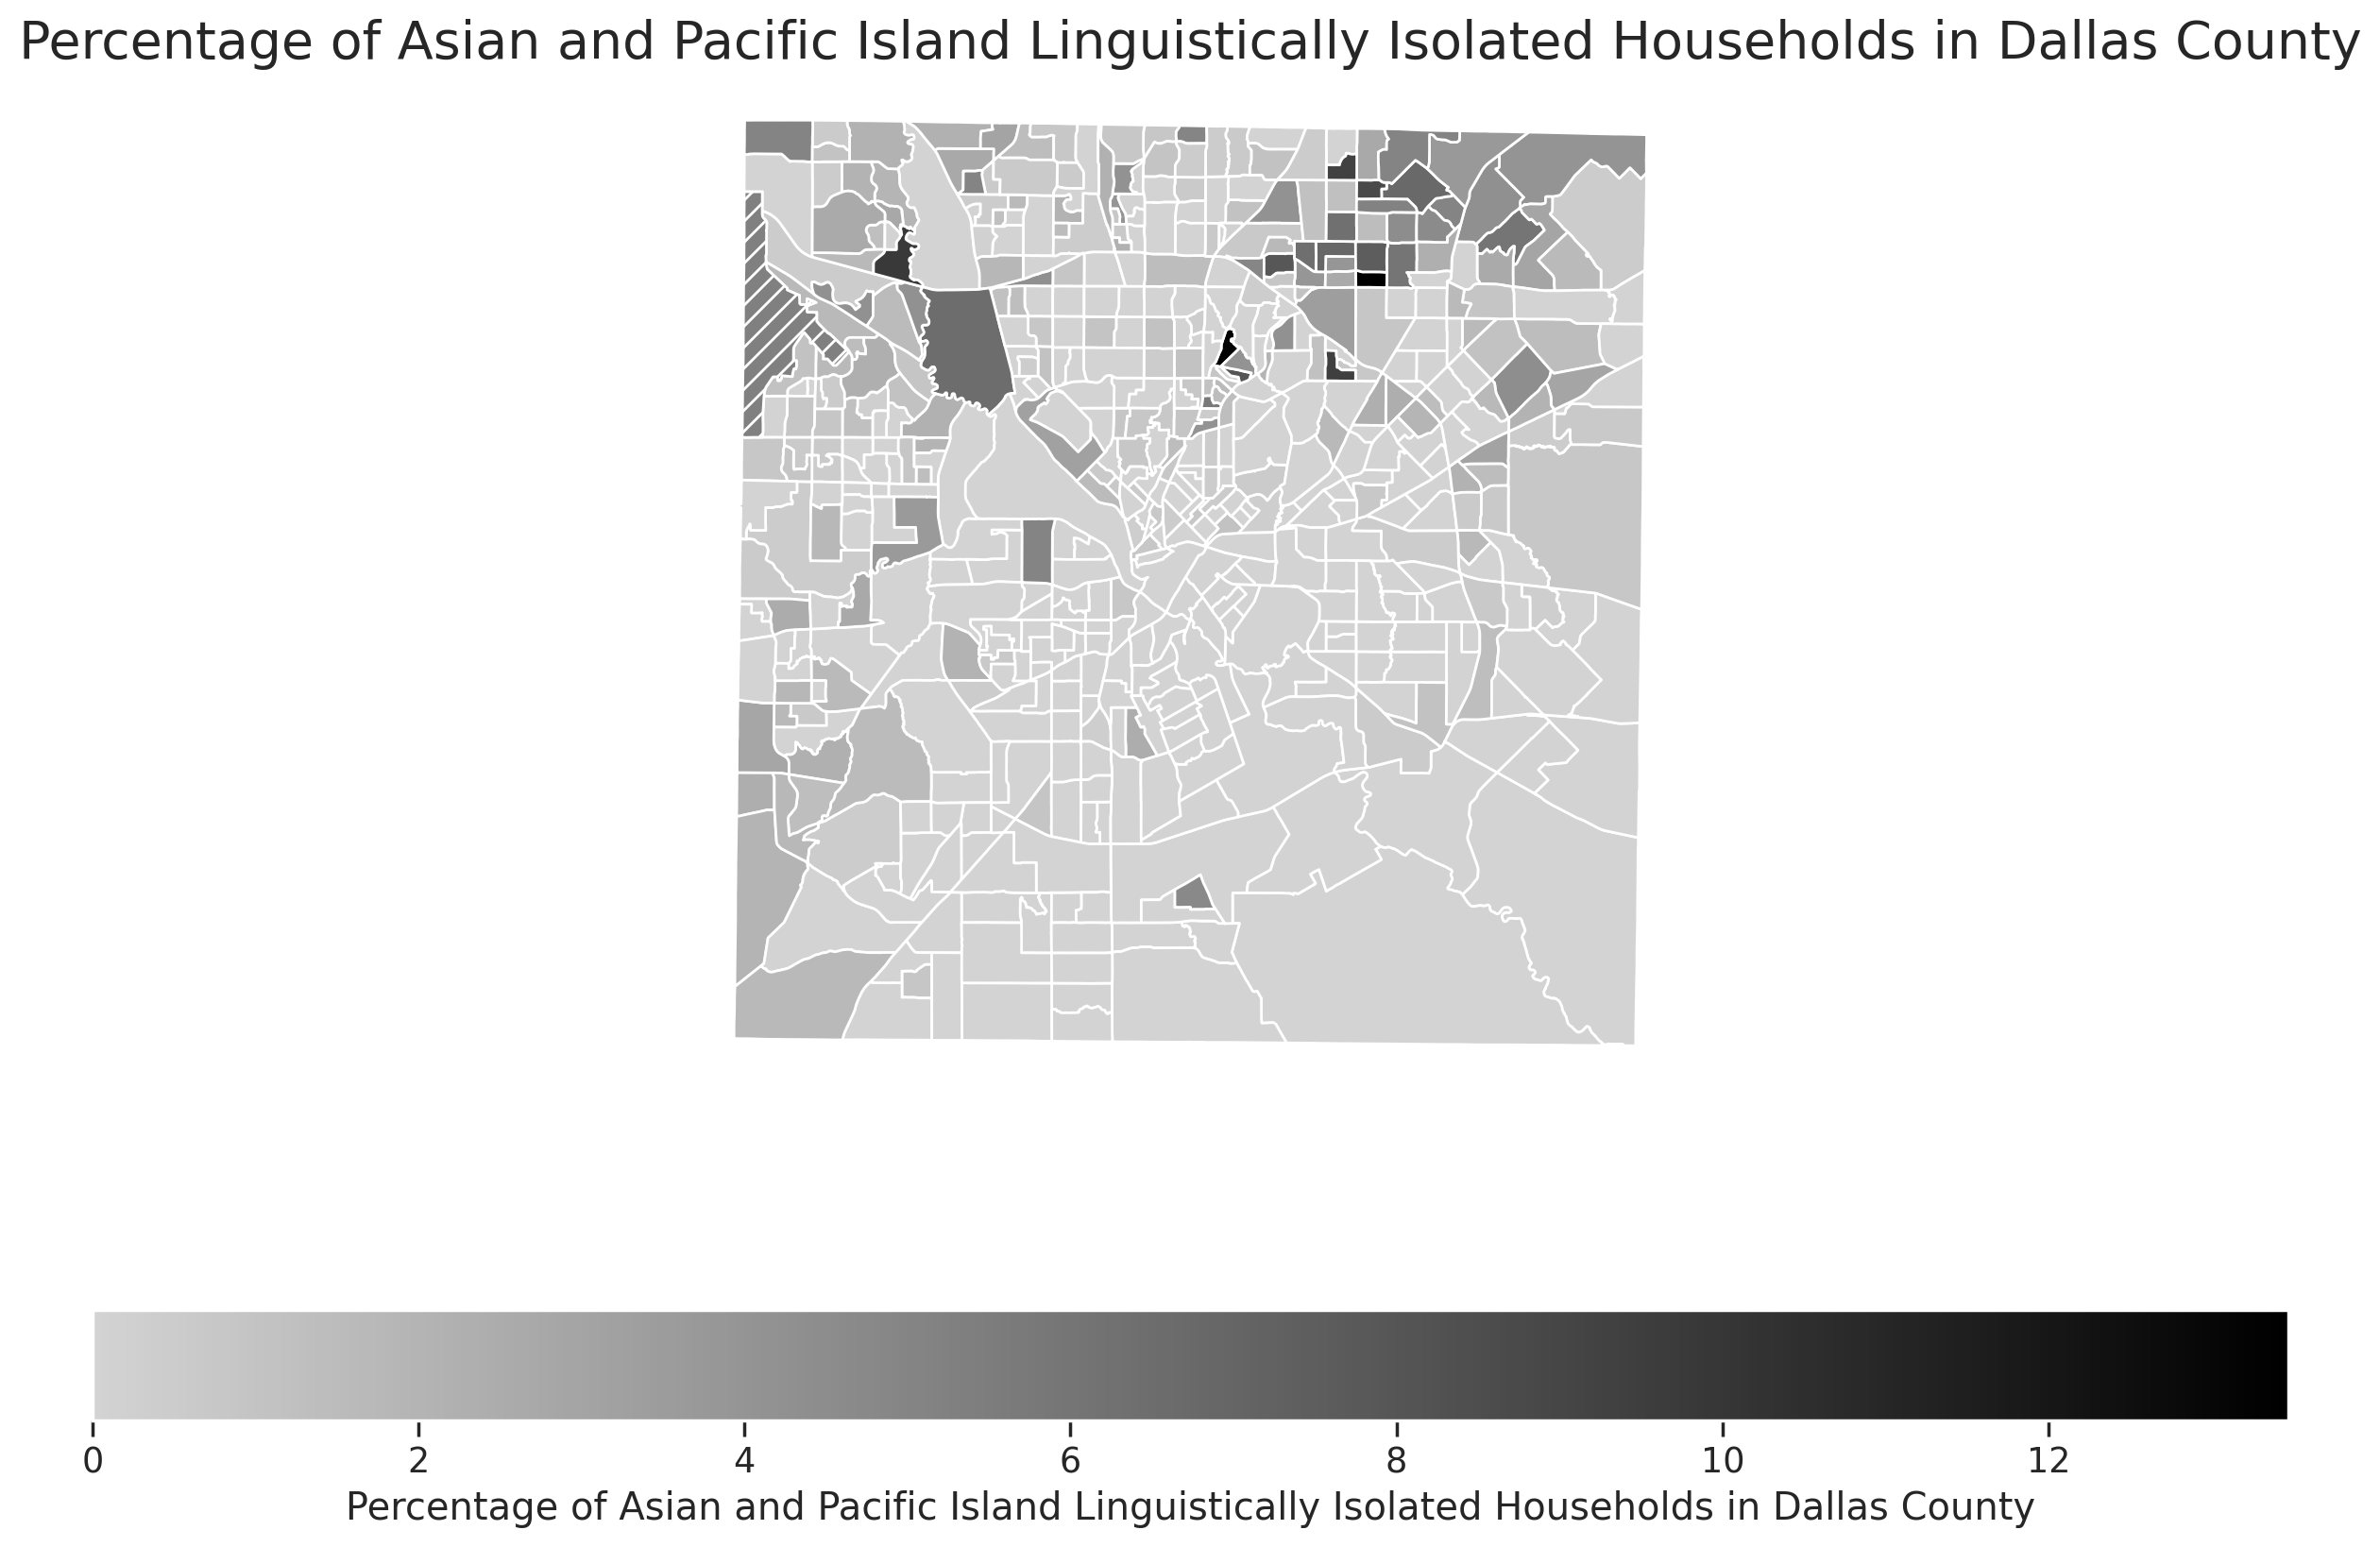

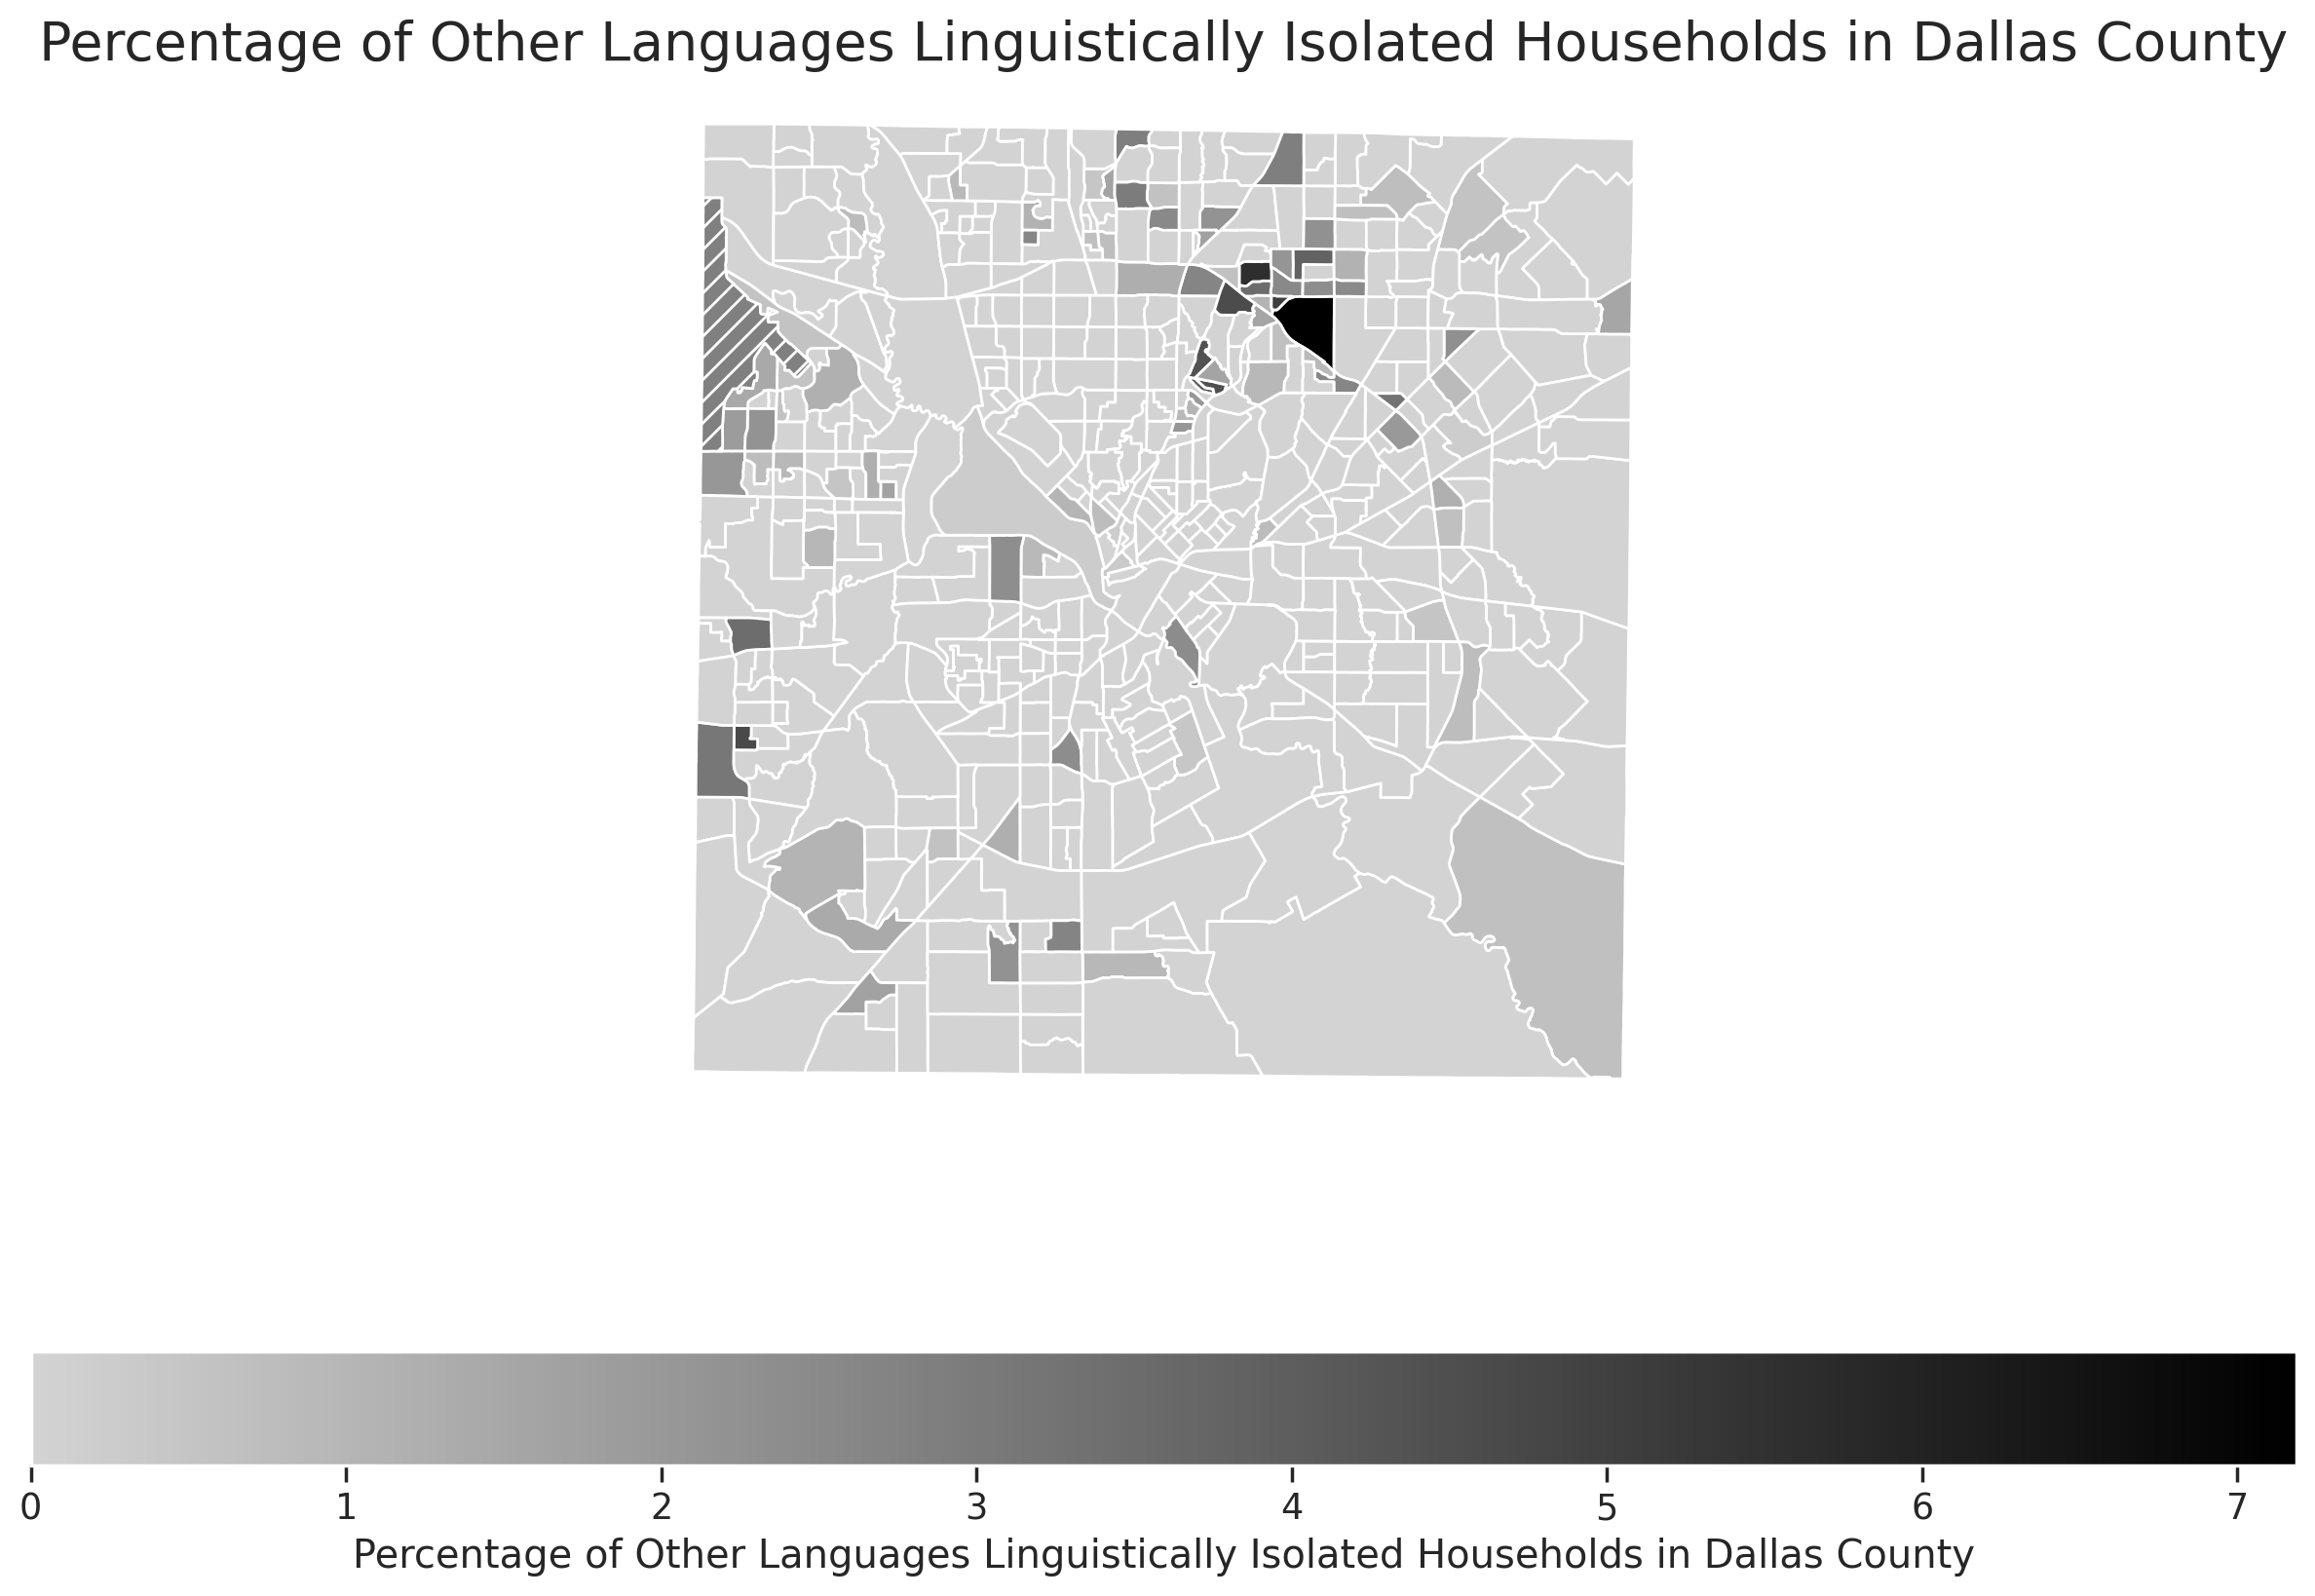

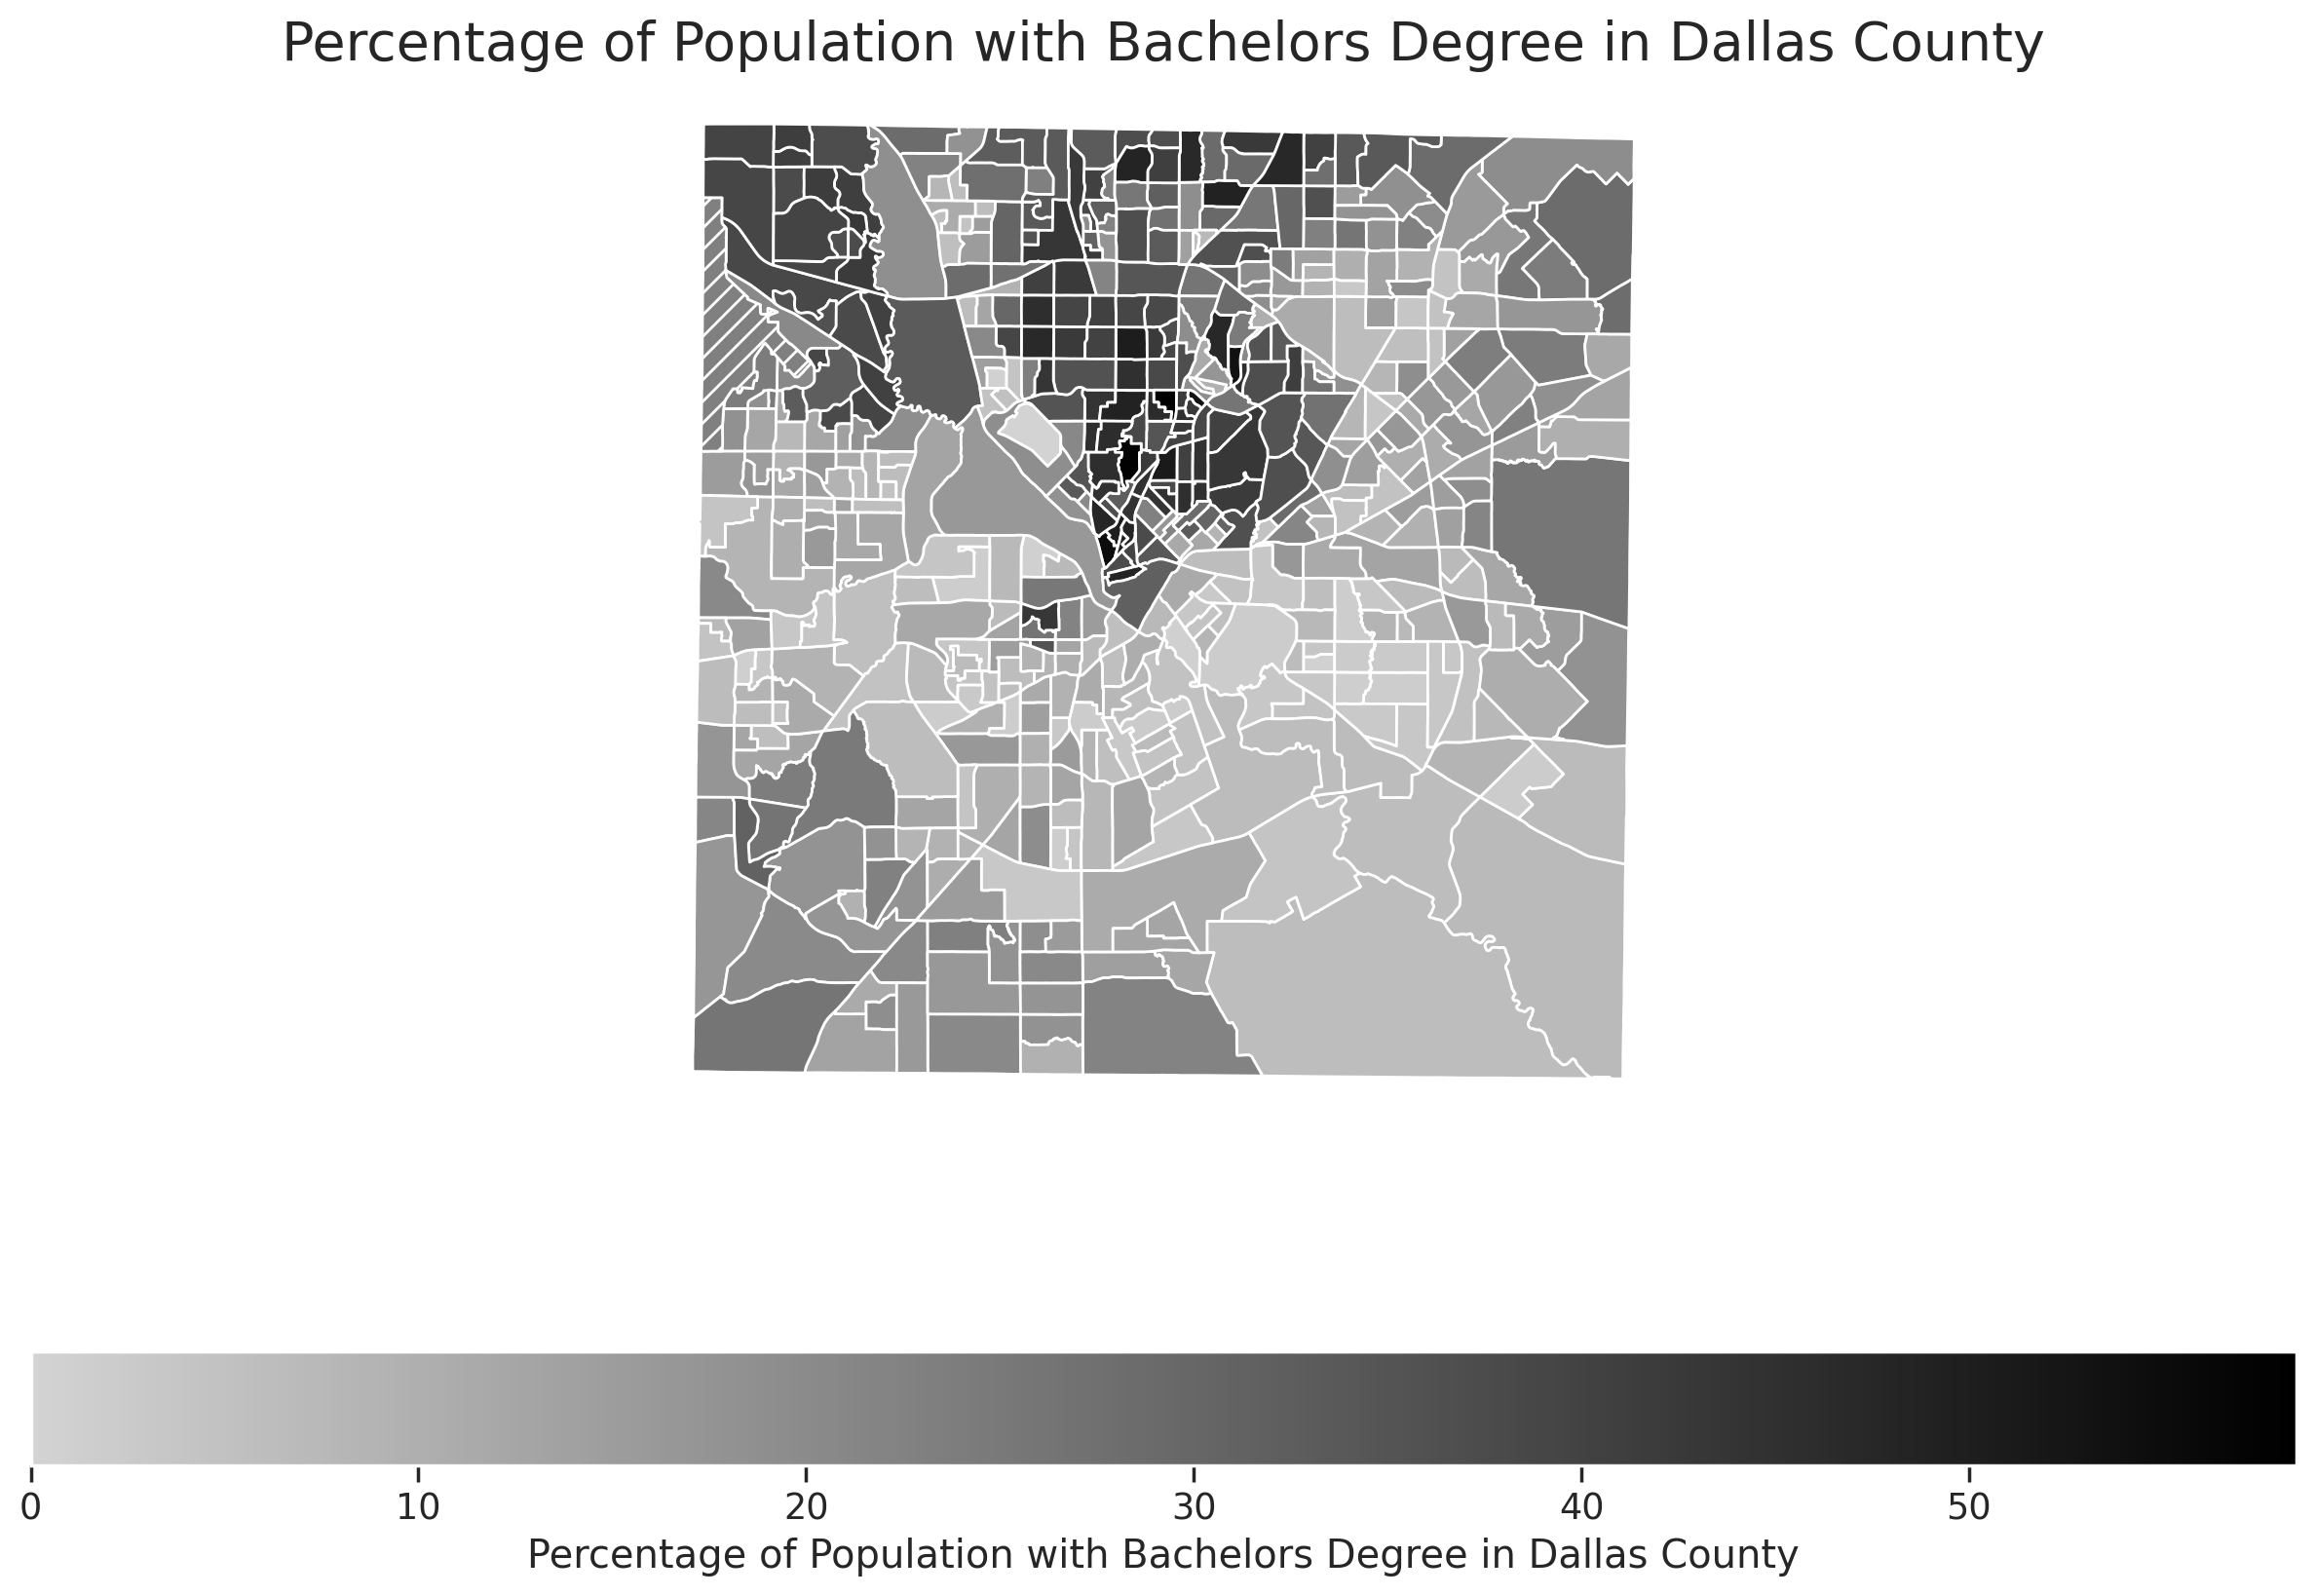

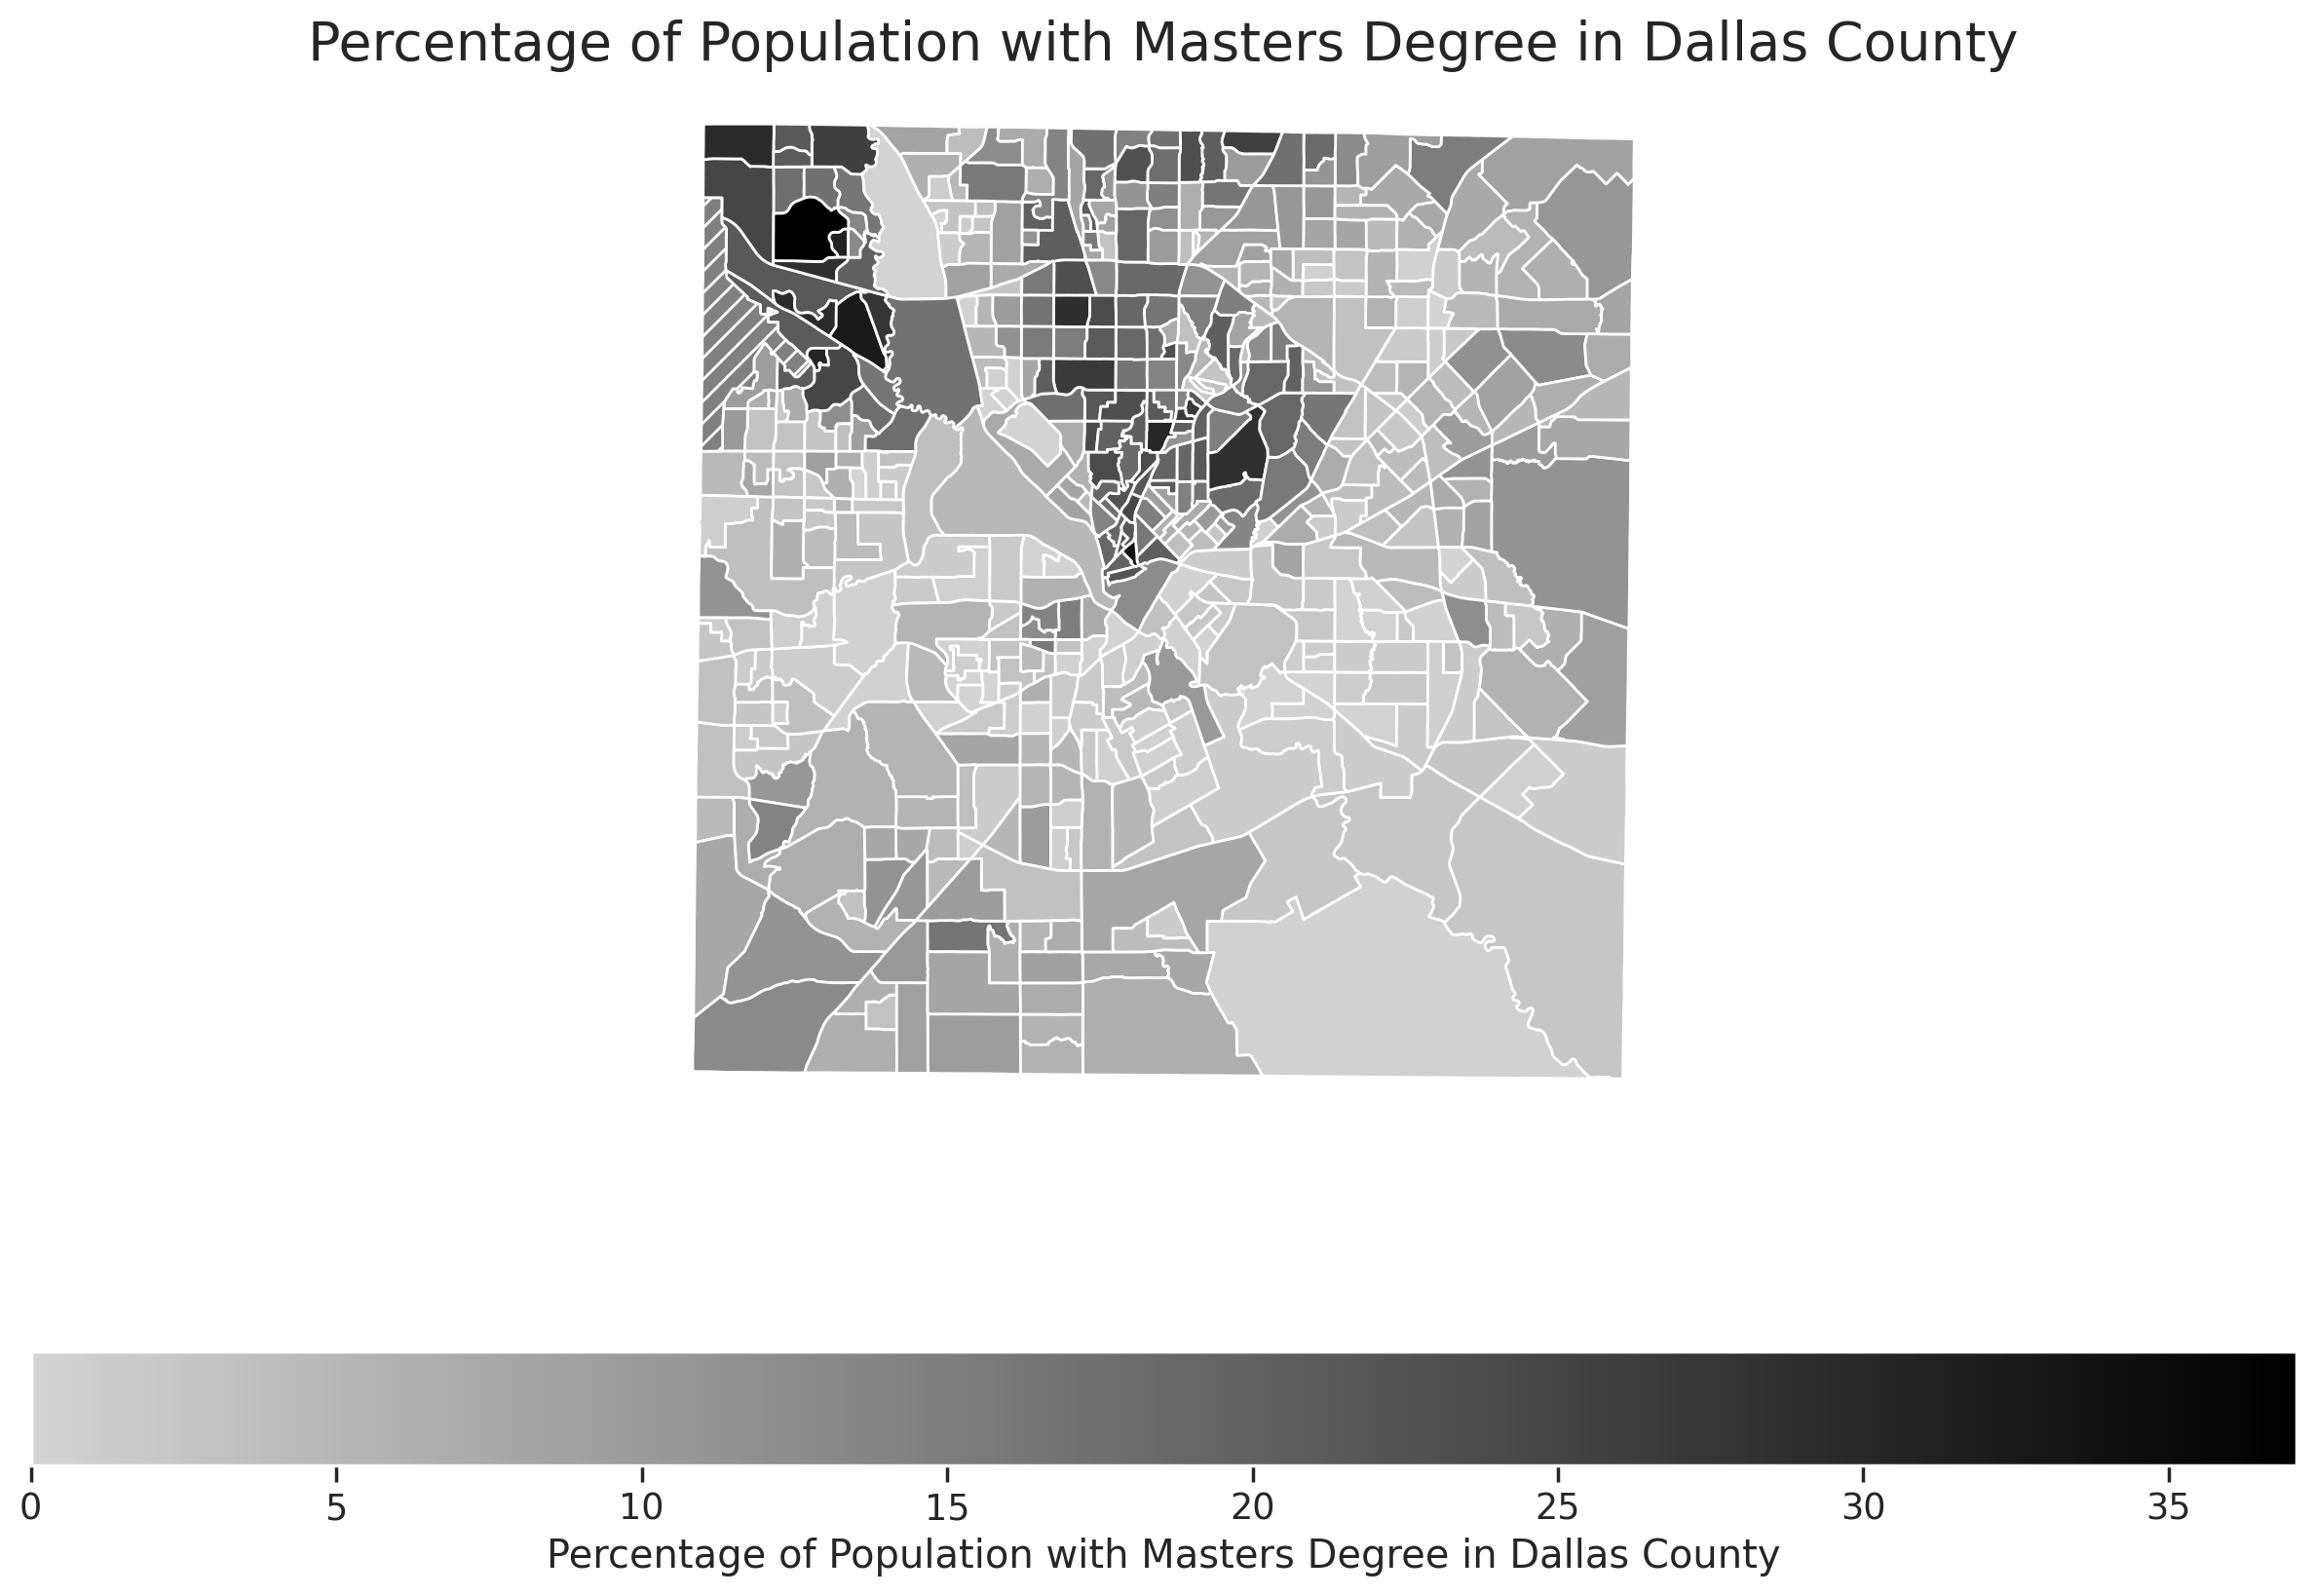

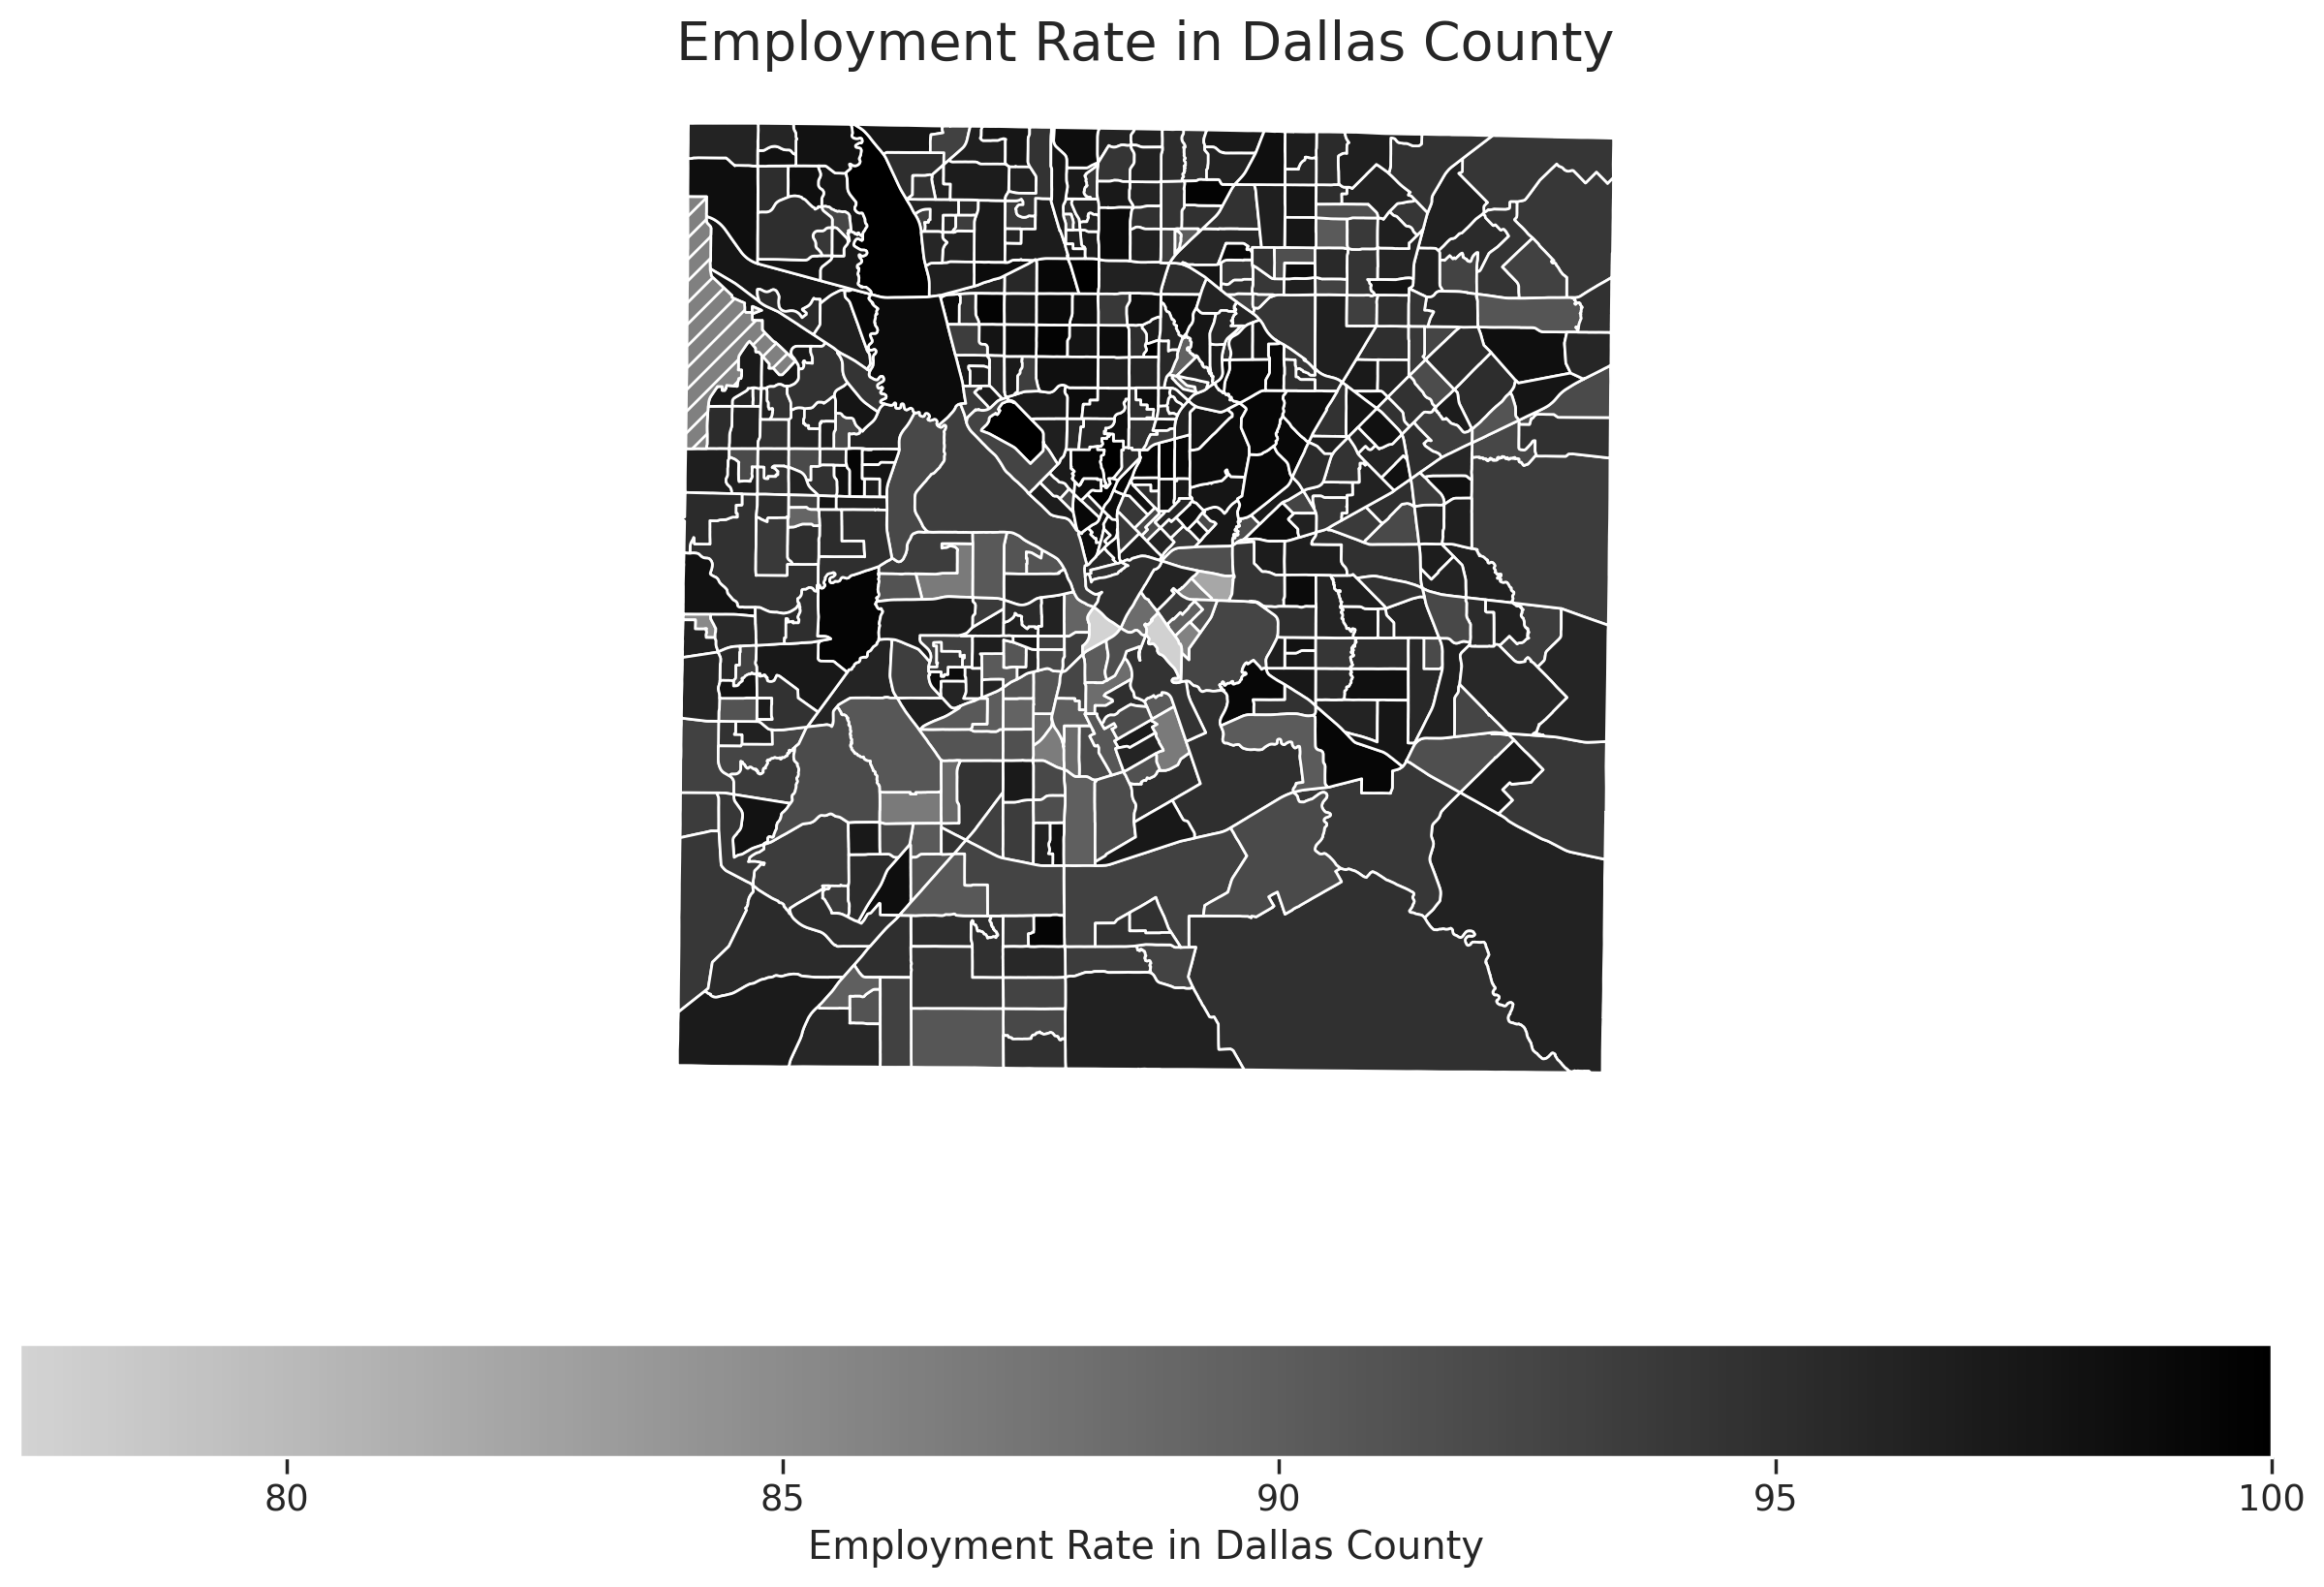

In [46]:
def plot_column(column, title, cmap, filename, dpi=300):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    merged.plot(column=column, ax=ax, legend=True,
                legend_kwds={'label': title, 'orientation': 'horizontal'},
                cmap=cmap, missing_kwds={"color": "grey", "label": "No Data", "hatch": "///"})
    ax.set_title(title, fontsize=20)
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', format='png', dpi=dpi)
    

# Plot the data using the specified colormaps and save each plot individually with higher resolution
plot_column('Median_Income', 'Median Income in Dallas County', income_cmap, 'Median_Income.png', dpi=300)
plot_column('Pct_Spanish_Linguistically_Isolated', 'Percentage of Spanish Linguistically Isolated Households in Dallas County', percent_cmap, 'Pct_Spanish_Linguistically_Isolated.png', dpi=300)
plot_column('Pct_Indo_European_Linguistically_Isolated', 'Percentage of Indo-European Linguistically Isolated Households in Dallas County', percent_cmap, 'Pct_Indo_European_Linguistically_Isolated.png', dpi=300)
plot_column('Pct_Asian_Pacific_Island_Linguistically_Isolated', 'Percentage of Asian and Pacific Island Linguistically Isolated Households in Dallas County', percent_cmap, 'Pct_Asian_Pacific_Island_Linguistically_Isolated.png', dpi=300)
plot_column('Pct_Other_Languages_Linguistically_Isolated', 'Percentage of Other Languages Linguistically Isolated Households in Dallas County', percent_cmap, 'Pct_Other_Languages_Linguistically_Isolated.png', dpi=300)
plot_column('Pct_Bachelors_Degree', 'Percentage of Population with Bachelors Degree in Dallas County', percent_cmap, 'Pct_Bachelors_Degree.png', dpi=300)
plot_column('Pct_Masters_Degree', 'Percentage of Population with Masters Degree in Dallas County', percent_cmap, 'Pct_Masters_Degree.png', dpi=300)
plot_column('Employment_Rate', 'Employment Rate in Dallas County', percent_cmap, 'Employment_Rate.png', dpi=300)


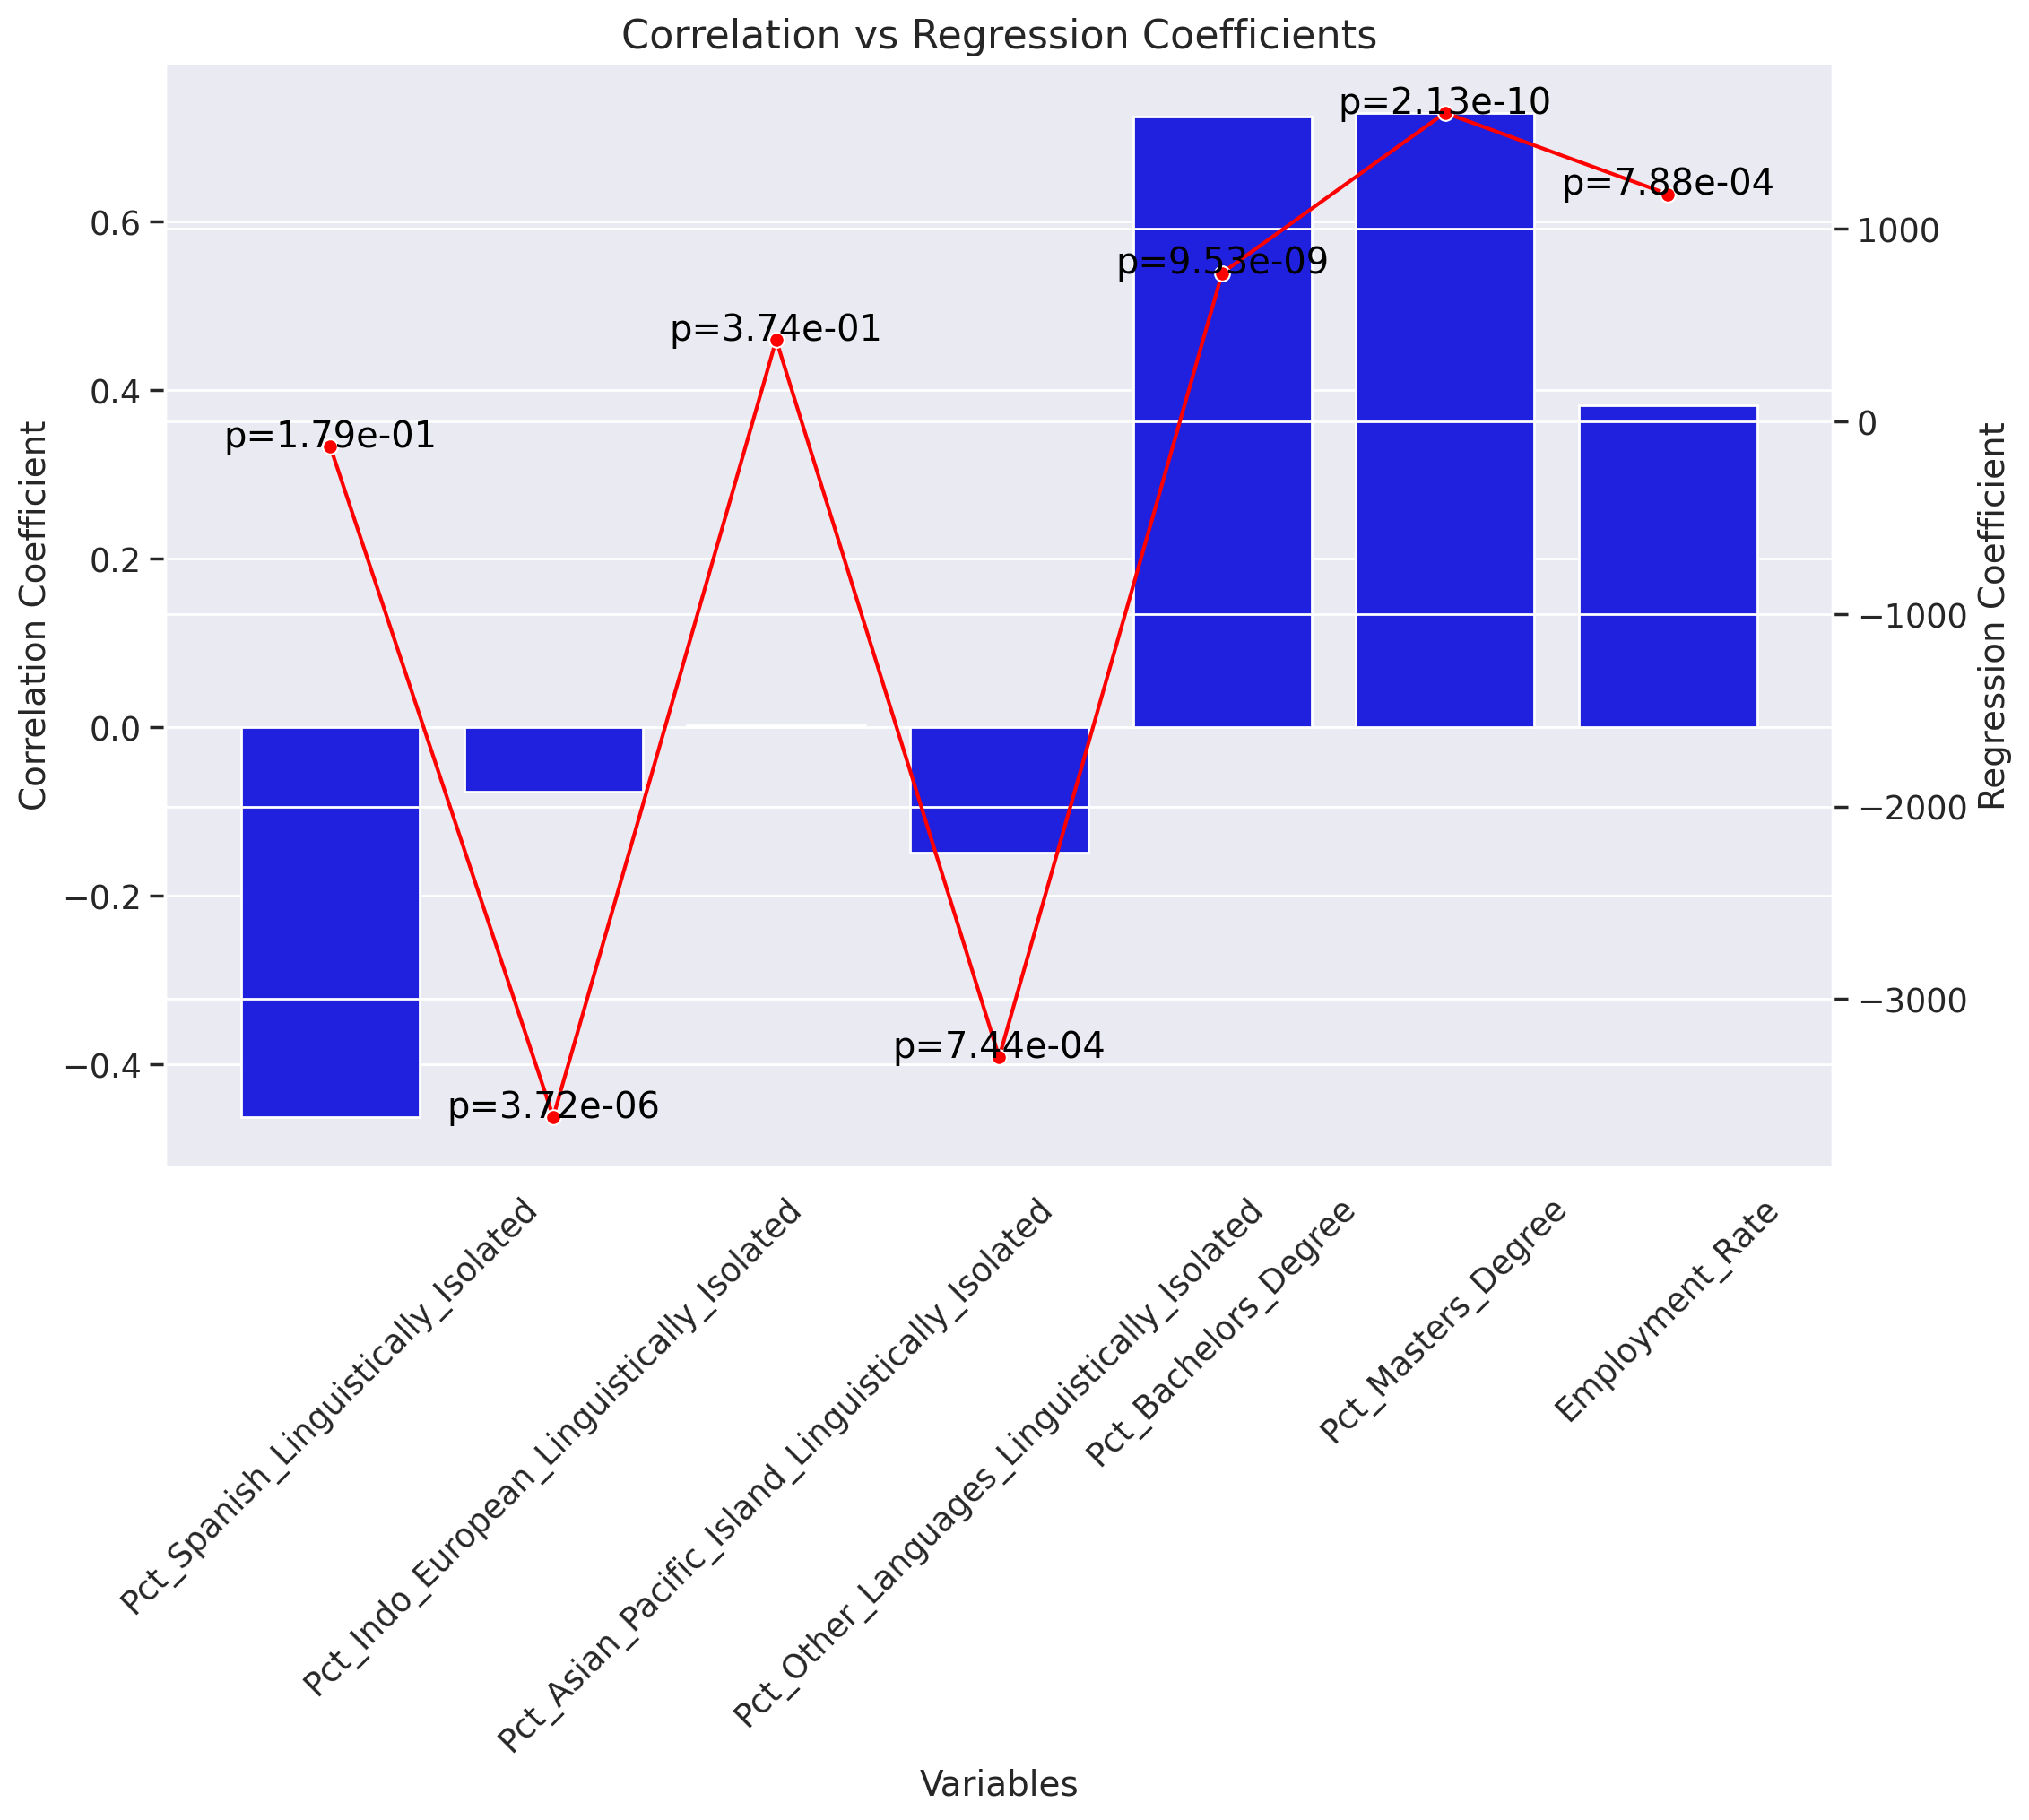


Summary of Correlation and Regression Results
Variable: Pct_Spanish_Linguistically_Isolated
  Correlation with Median Income: -0.463
  Regression Coefficient: -130.94
  P-Value: 1.787e-01
--------------------------------------------------
Variable: Pct_Indo_European_Linguistically_Isolated
  Correlation with Median Income: -0.076
  Regression Coefficient: -3612.65
  P-Value: 3.724e-06
--------------------------------------------------
Variable: Pct_Asian_Pacific_Island_Linguistically_Isolated
  Correlation with Median Income: 0.003
  Regression Coefficient: 424.49
  P-Value: 3.741e-01
--------------------------------------------------
Variable: Pct_Other_Languages_Linguistically_Isolated
  Correlation with Median Income: -0.149
  Regression Coefficient: -3302.38
  P-Value: 7.441e-04
--------------------------------------------------
Variable: Pct_Bachelors_Degree
  Correlation with Median Income: 0.725
  Regression Coefficient: 771.47
  P-Value: 9.535e-09
-----------------------------

In [47]:
correlation_summary = pd.DataFrame({
    'Variable': ['Pct_Spanish_Linguistically_Isolated', 'Pct_Indo_European_Linguistically_Isolated',
                 'Pct_Asian_Pacific_Island_Linguistically_Isolated', 'Pct_Other_Languages_Linguistically_Isolated',
                 'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 'Employment_Rate'],
    'Correlation': [correlation['Median_Income']['Pct_Spanish_Linguistically_Isolated'],
                    correlation['Median_Income']['Pct_Indo_European_Linguistically_Isolated'],
                    correlation['Median_Income']['Pct_Asian_Pacific_Island_Linguistically_Isolated'],
                    correlation['Median_Income']['Pct_Other_Languages_Linguistically_Isolated'],
                    correlation['Median_Income']['Pct_Bachelors_Degree'],
                    correlation['Median_Income']['Pct_Masters_Degree'],
                    correlation['Median_Income']['Employment_Rate']],
    'Regression Coefficient': [model.params['Pct_Spanish_Linguistically_Isolated'],
                               model.params['Pct_Indo_European_Linguistically_Isolated'],
                               model.params['Pct_Asian_Pacific_Island_Linguistically_Isolated'],
                               model.params['Pct_Other_Languages_Linguistically_Isolated'],
                               model.params['Pct_Bachelors_Degree'],
                               model.params['Pct_Masters_Degree'],
                               model.params['Employment_Rate']],
    'P-Value': [model.pvalues['Pct_Spanish_Linguistically_Isolated'],
                model.pvalues['Pct_Indo_European_Linguistically_Isolated'],
                model.pvalues['Pct_Asian_Pacific_Island_Linguistically_Isolated'],
                model.pvalues['Pct_Other_Languages_Linguistically_Isolated'],
                model.pvalues['Pct_Bachelors_Degree'],
                model.pvalues['Pct_Masters_Degree'],
                model.pvalues['Employment_Rate']]
})

# Plot the correlation vs regression coefficients
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for correlation
ax1 = sns.barplot(x='Variable', y='Correlation', data=correlation_summary, color='blue')
ax1.set_ylabel('Correlation Coefficient', fontsize=14)
ax1.set_xlabel('Variables', fontsize=14)
ax1.set_title('Correlation vs Regression Coefficients', fontsize=16)
ax1.tick_params(axis='x', rotation=45)

# Create a secondary y-axis to plot the regression coefficients
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='Variable', y='Regression Coefficient', data=correlation_summary, marker='o', color='red')
ax2.set_ylabel('Regression Coefficient', fontsize=14)

# Annotate p-values on the regression coefficient points
for i in range(correlation_summary.shape[0]):
    ax2.text(i, correlation_summary['Regression Coefficient'][i], f"p={correlation_summary['P-Value'][i]:.2e}", 
             color='black', ha='center')

plt.show()

# Print out the summary of correlation and regression results
print("\nSummary of Correlation and Regression Results")
print("=" * 50)
for index, row in correlation_summary.iterrows():
    print(f"Variable: {row['Variable']}")
    print(f"  Correlation with Median Income: {row['Correlation']:.3f}")
    print(f"  Regression Coefficient: {row['Regression Coefficient']:.2f}")
    print(f"  P-Value: {row['P-Value']:.3e}")
    print("-" * 50)

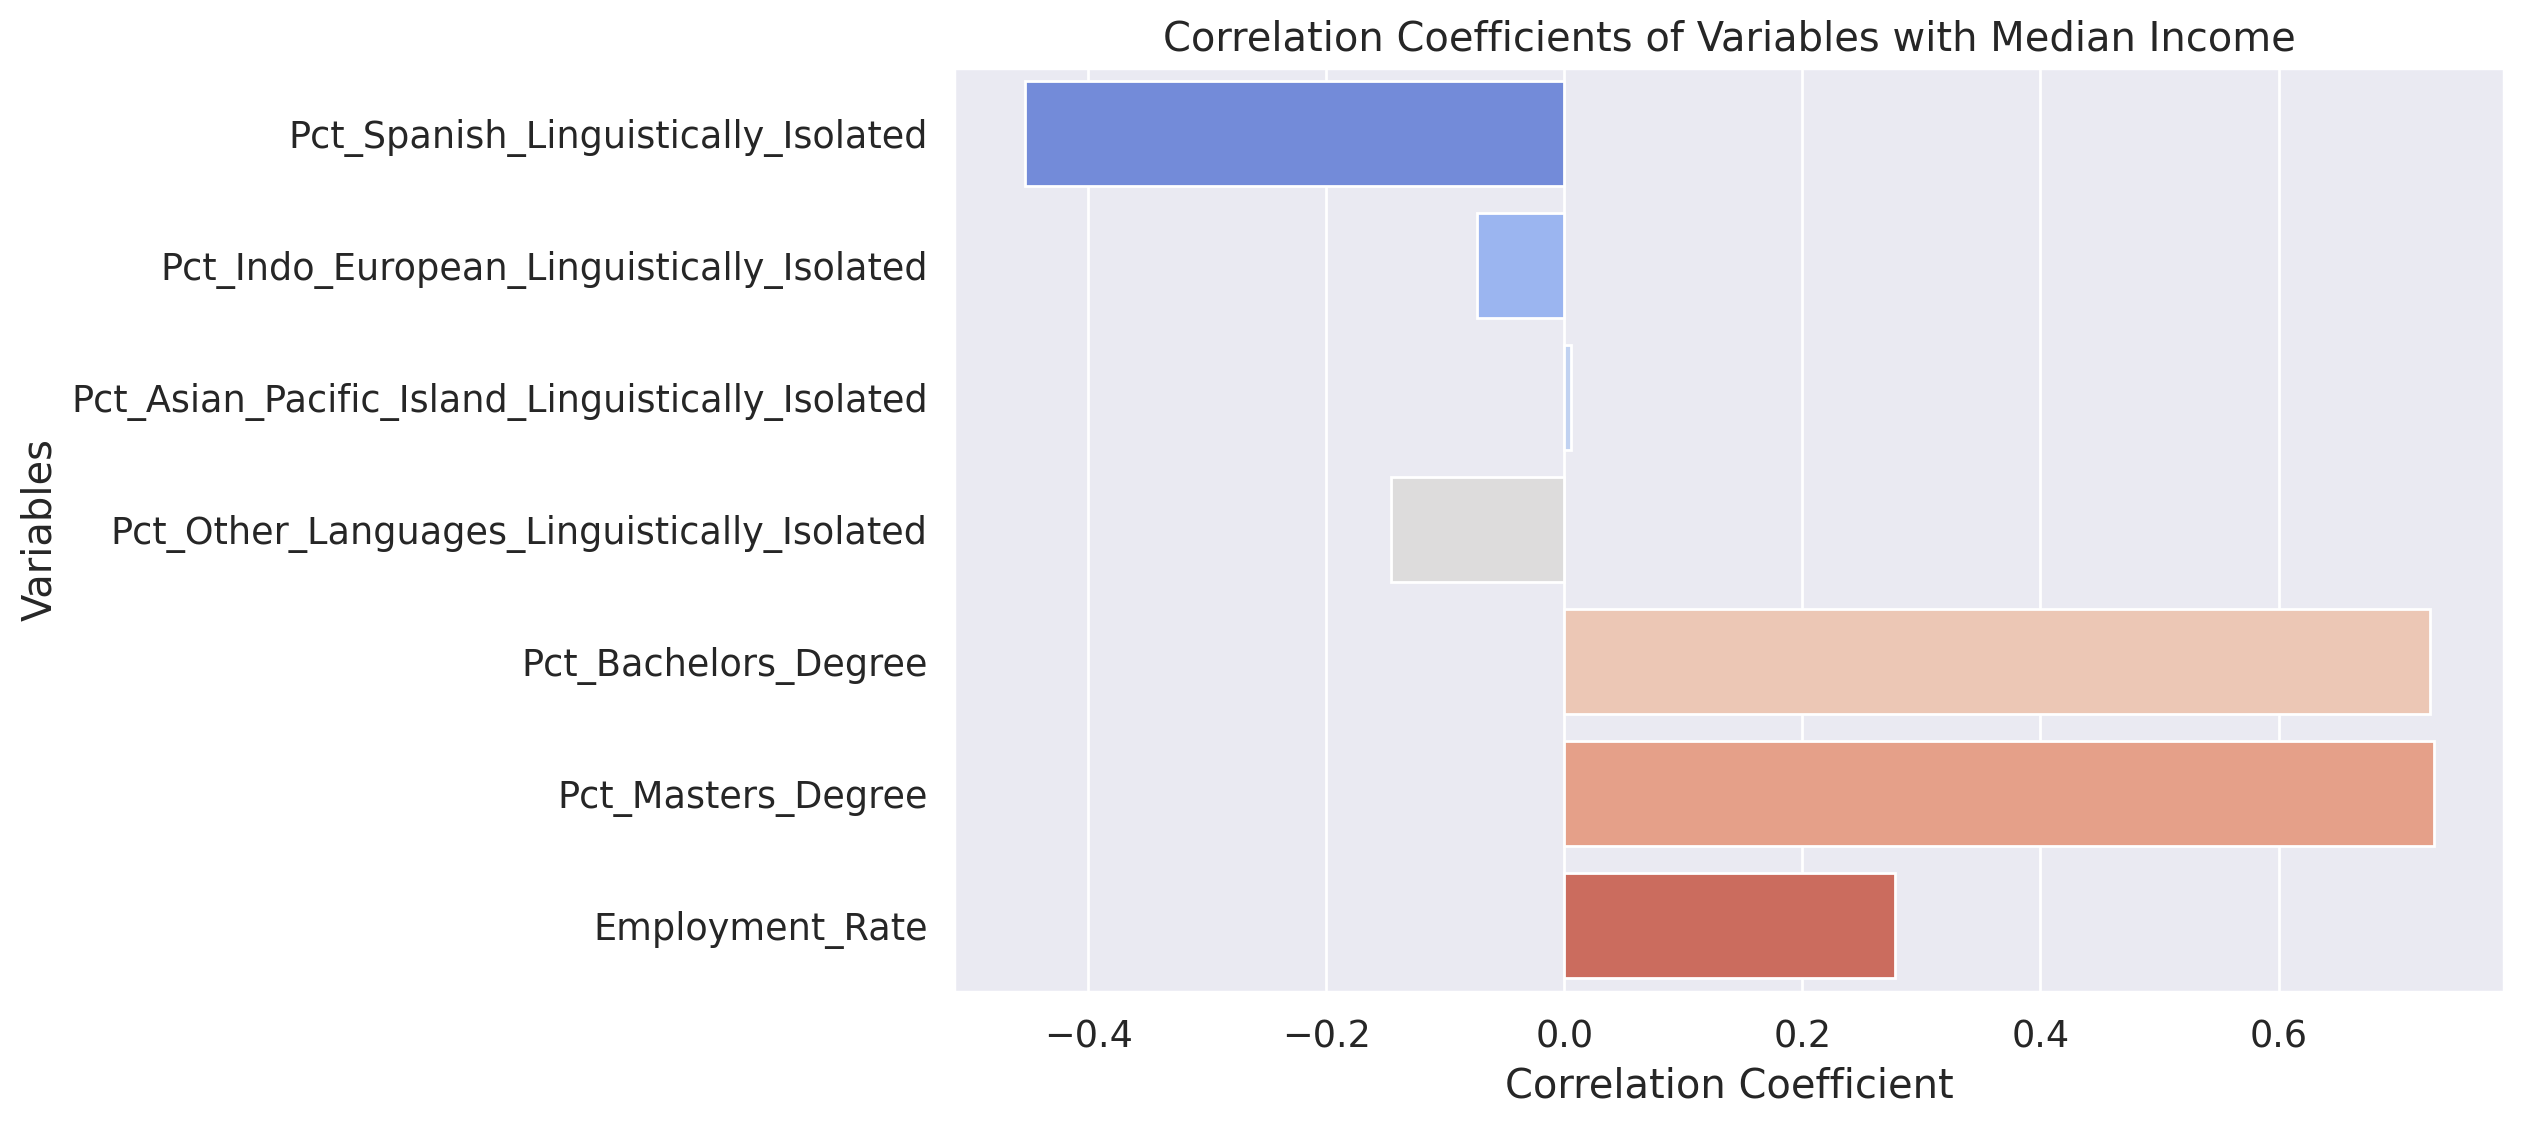

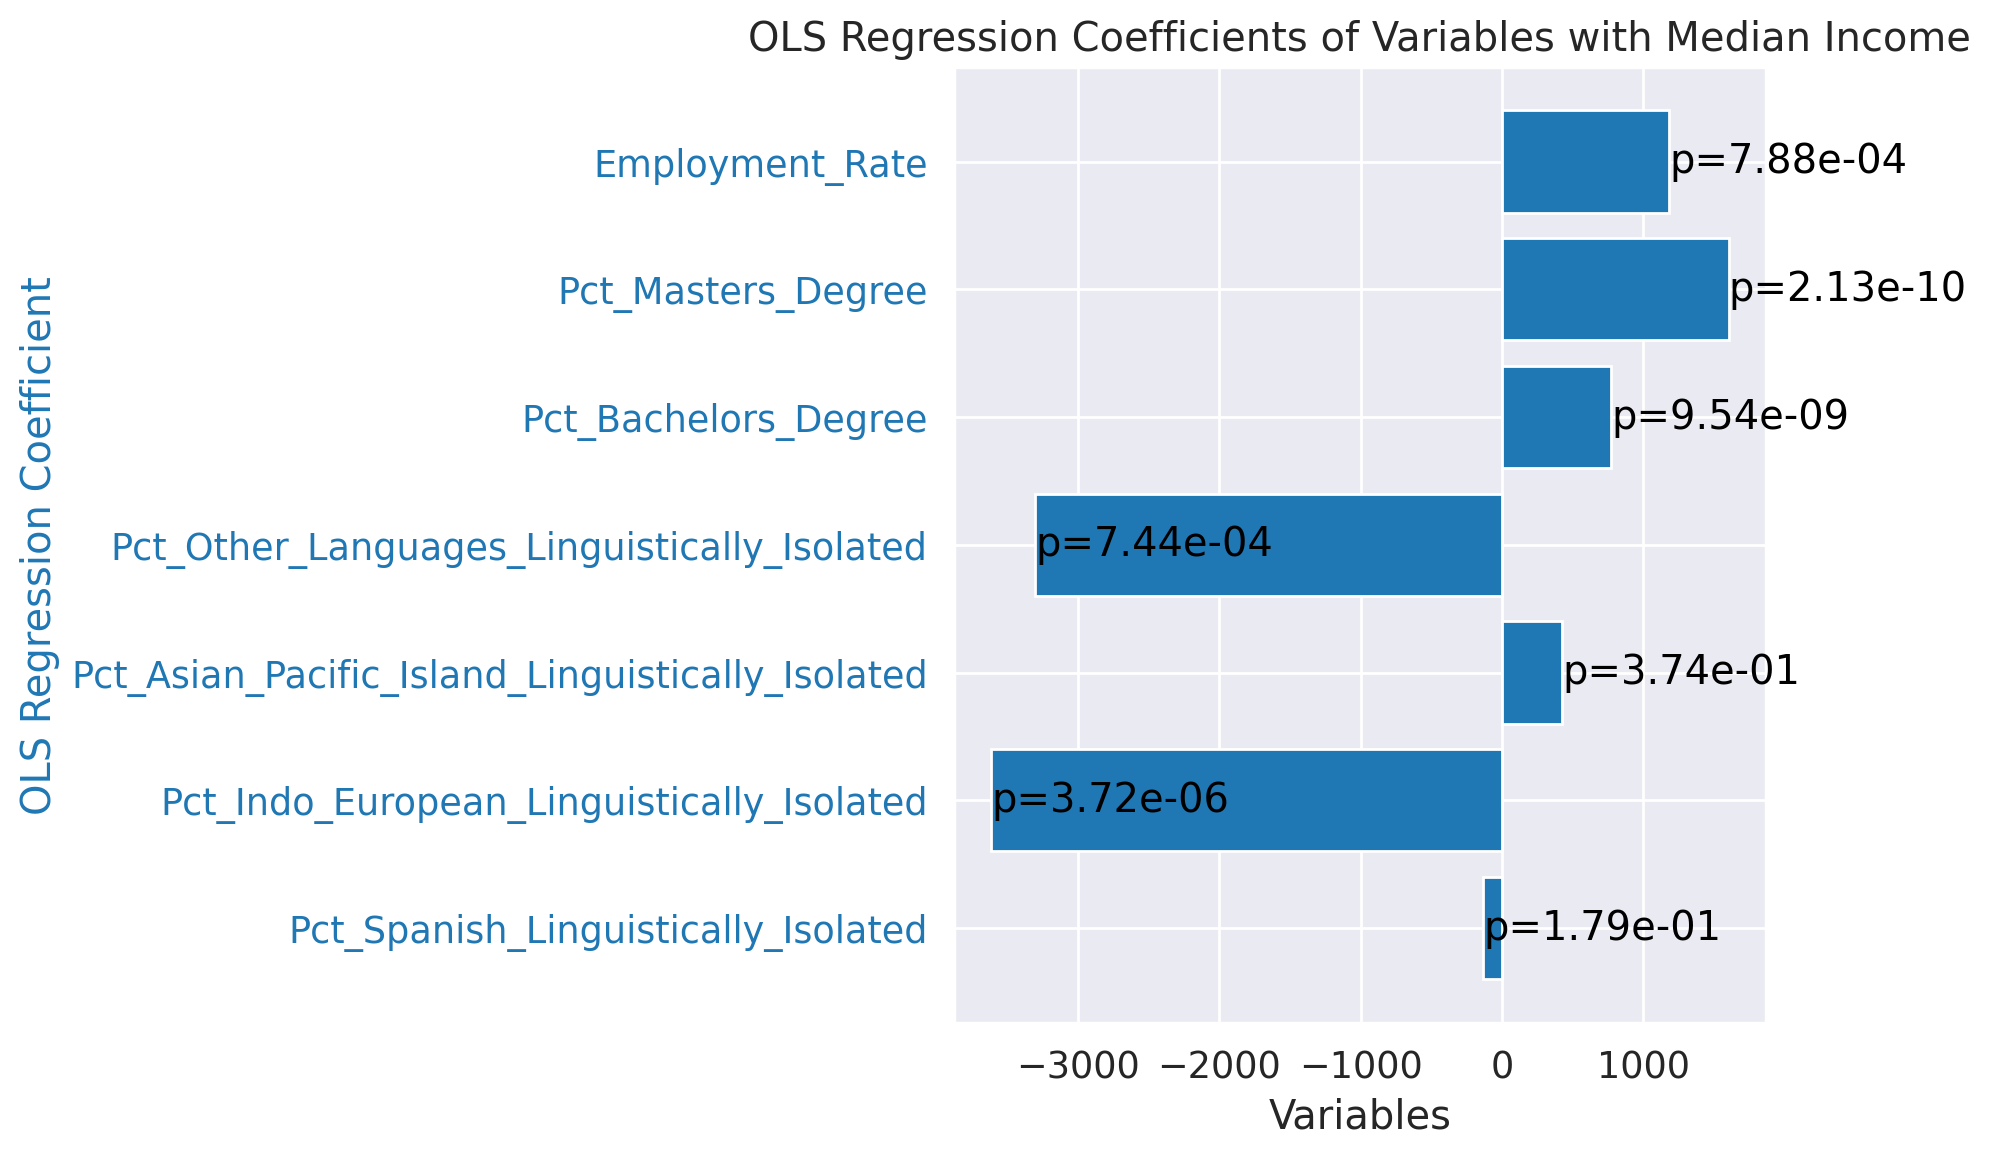

In [51]:

# Define the correlation and regression coefficients along with their p-values
correlation_data = {
    'Variables': ['Pct_Spanish_Linguistically_Isolated', 'Pct_Indo_European_Linguistically_Isolated',
                  'Pct_Asian_Pacific_Island_Linguistically_Isolated', 'Pct_Other_Languages_Linguistically_Isolated',
                  'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 'Employment_Rate'],
    'Correlation Coefficient': [-0.453345, -0.0730991, 0.0058609, -0.145565, 0.727011, 0.730413, 0.277483]
}

regression_data = {
    'Variables': ['Pct_Spanish_Linguistically_Isolated', 'Pct_Indo_European_Linguistically_Isolated',
                  'Pct_Asian_Pacific_Island_Linguistically_Isolated', 'Pct_Other_Languages_Linguistically_Isolated',
                  'Pct_Bachelors_Degree', 'Pct_Masters_Degree', 'Employment_Rate'],
    'OLS Regression Coefficient': [-130.94, -3612.64, 424.49, -3302.38, 771.47, 1603.79, 1181.24],
    'OLS P-value': [0.1787, 3.724e-06, 0.3741, 7.441e-04, 9.535e-09, 2.126e-10, 7.880e-04]
}

correlation_df = pd.DataFrame(correlation_data)
regression_df = pd.DataFrame(regression_data)

# Plotting correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation Coefficient', y='Variables', data=correlation_df, dodge=False, palette='coolwarm')
plt.title('Correlation Coefficients of Variables with Median Income')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.savefig('Correlation_Coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotting OLS regression coefficients
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Variables')
ax1.set_ylabel('OLS Regression Coefficient', color=color)
ax1.barh(regression_df['Variables'], regression_df['OLS Regression Coefficient'], color=color, align='center')
ax1.tick_params(axis='y', labelcolor=color)

# Adding the p-values on the bars
for index, value in enumerate(regression_df['OLS Regression Coefficient']):
    plt.text(value, index, f'p={regression_df["OLS P-value"][index]:.2e}', color='black', ha='left', va='center')

plt.title('OLS Regression Coefficients of Variables with Median Income')
fig.tight_layout()
plt.savefig('OLS_Regression_Coefficients.png', dpi=300, bbox_inches='tight')
plt.show()